In [1]:
#plots
import matplotlib.pylab as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns; sns.set()
from matplotlib import colors
from itertools import cycle

#data
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import json
from collections import OrderedDict
from scipy.stats import norm as gauss
import random
from random import shuffle

#ML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# import keras
# from keras import objectives
# from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Input, Multiply, Add, Lambda, Layer
# from keras.layers.core import Dense, Activation, Flatten, RepeatVector
# from keras.layers.wrappers import TimeDistributed
# from keras.layers.recurrent import GRU
# from keras.layers.convolutional import Convolution1D
# from keras.optimizers import Adam, Nadam
# from keras.objectives import binary_crossentropy #objs or losses

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty

#misc/scripts
import sys
sys.path.insert(0, '../')
from scripts import *

vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

vae_models = ['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

#search with single seed data
df1 = pd.read_csv('../data/structure_search_results/vae_1_structures.csv')
df2 = pd.read_csv('../data/structure_search_results/vae_2_structures.csv')
df3 = pd.read_csv('../data/structure_search_results/vae_3_structures.csv')
df4 = pd.read_csv('../data/structure_search_results/vae_4_structures.csv')
df5 = pd.read_csv('../data/structure_search_results/vae_5_structures.csv')
dfs = [df1, df2, df3, df4, df5]

#salt data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']

Using TensorFlow backend.


In [2]:
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from sklearn.preprocessing import StandardScaler
from numpy import log
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

from numpy import array
from keras.models import load_model
from os.path import dirname, join
from rdkit import Chem
from rdkit.six import iteritems
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.pyplot import figure
from rdkit.Chem.Draw.canvasbase import CanvasBase
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
from scipy.constants import golden as phi

def raad(y_true, y_pred):
    return np.sum(np.abs((y_pred-y_true)/y_true))/len(y_true)*100

class Canvas(CanvasBase):

    def __init__(self, size, name='', imageType='svg'):
        self._name = name
        self.size = size
        dpi = max(size[0], size[1])
        figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
        self._figure = figure(figsize=figsize)
        self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
        self._axes.set_xticklabels('')
        self._axes.set_yticklabels('')
        self._axes.get_xaxis().set_visible(False)
        self._axes.get_yaxis().set_visible(False)
        self._dpi = dpi

    def rescalePt(self, p1):
        return [float(p1[0]) / self._dpi, float(self.size[1] - p1[1]) / self._dpi]

    def addCanvasLine(self, p1, p2, color=(0, 0, 0), color2=None, **kwargs):
        canvas = self._axes
        p1 = self.rescalePt(p1)
        p2 = self.rescalePt(p2)
        if color2 and color2 != color:
            mp = (p1[0] + p2[0]) / 2., (p1[1] + p2[1]) / 2.
            canvas.add_line(Line2D((p1[0], mp[0]), (p1[1], mp[1]), color=color, **kwargs))
            canvas.add_line(Line2D((mp[0], p2[0]), (mp[1], p2[1]), color=color2, **kwargs))
        else:
            canvas.add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=color, **kwargs))
    
    def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
        canvas = self._axes
        ps = [self.rescalePt(x) for x in ps]
        canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))
    def addCanvasText(self, text, pos, font, color=(0, 0, 0), **kwargs):
        import re
        pos = self.rescalePt(pos)
        canvas = self._axes
        text = re.sub(r'<.*?>', '', text)
        orientation = kwargs.get('orientation', 'E')
        halign = 'center'
        valign = 'center'
        if orientation == 'E':
            halign = 'left'
        elif orientation == 'W':
            halign = 'right'
        elif orientation == 'S':
            valign = 'top'
        elif orientation == 'N':
            valign = 'bottom'

        annot = canvas.annotate(text, (pos[0], pos[1]), color=color, verticalalignment=valign,
                            horizontalalignment=halign, weight=font.weight, size=font.size * 2.0,
                            family=font.face)

        try:
            bb = annot.get_window_extent(renderer=self._figure.canvas.get_renderer())
            w, h = bb.width, bb.height
            tw, th = canvas.transData.inverted().transform((w, h))
        except AttributeError:
            tw, th = 0.1, 0.1  # <- kludge
        return (tw, th, 0)

    def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
        canvas = self._axes
        ps = [self.rescalePt(x) for x in ps]
        canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))

**Training histories**

In [3]:
vae_models

['M1.h5', 'M2.h5', 'M3.h5', 'M4.h5', 'M5.h5']

In [4]:
chemvae = CationVAE()
f = open("../data/gdb_char_to_index.json", "r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
chemvae.create(char_set, max_length=51, weights_file='../models/{}'.format(vae_models[0]), qspr=False)

In [5]:
chemvae.autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 51, 33)       0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 43, 9)        2682        input_3[0][0]                    
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 35, 9)        738         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 25, 10)       1000        conv_2[0][0]                     
____________________________________________________________________________________________

**check model sanity**

In [6]:
#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
chars_in_dict = len(char_list)
index_to_char = dict((i, c) for i, c in enumerate(char_list))

#model
chemvae = MoleculeVAE()
chemvae.create(char_set, max_length=smile_max_length, weights_file='../models/GEN3.h5', qspr=True)

df = pd.read_csv('../data/GDB/GDB17.1000000') #1Mil GDB entries, easy on memory
df.columns = ['smiles']
data_epoch_size = 500
for _epoch in range(1):
    selected = df['smiles'][data_epoch_size*_epoch:data_epoch_size*(_epoch+1)].reset_index(drop=True)
    values = pd.Series(selected.values + '.' + selected[::-1].values)

FileNotFoundError: [Errno 2] File ../data/GDB/GDB17.1000000 does not exist: '../data/GDB/GDB17.1000000'

In [7]:
seed = salts[random.randint(0,len(salts))]
print("seed:\t{}".format(seed))
string = ""
for i in chemvae.autoencoder.predict(one_hot(seed, char_to_index, smile_max_length=105))[:1]:
    if len(i.shape) > 2:
        i = i[0] #for qspr chemvae there is an extra dim
    for j in i:
#         print(j.shape)
        index = sample(j, temperature=0.2)
        string += index_to_char[index]
print("sample:\t{}".format(string))

seed:	CN(C)C(=[NH2+])N(C)C.C(=O)(C(F)(F)F)[O-]
sample:	s5.(-@e1/7s2N\e+##)F(\s@7P8s+2 (.\41l#4oe(\cB]nenrSB1.n=#)\[NPNsCrl@F)-#/NC[)@#CO=S2oo)7- [en@@OFCBc(c\ N


**evolution of the latent space**

*first million training samples*

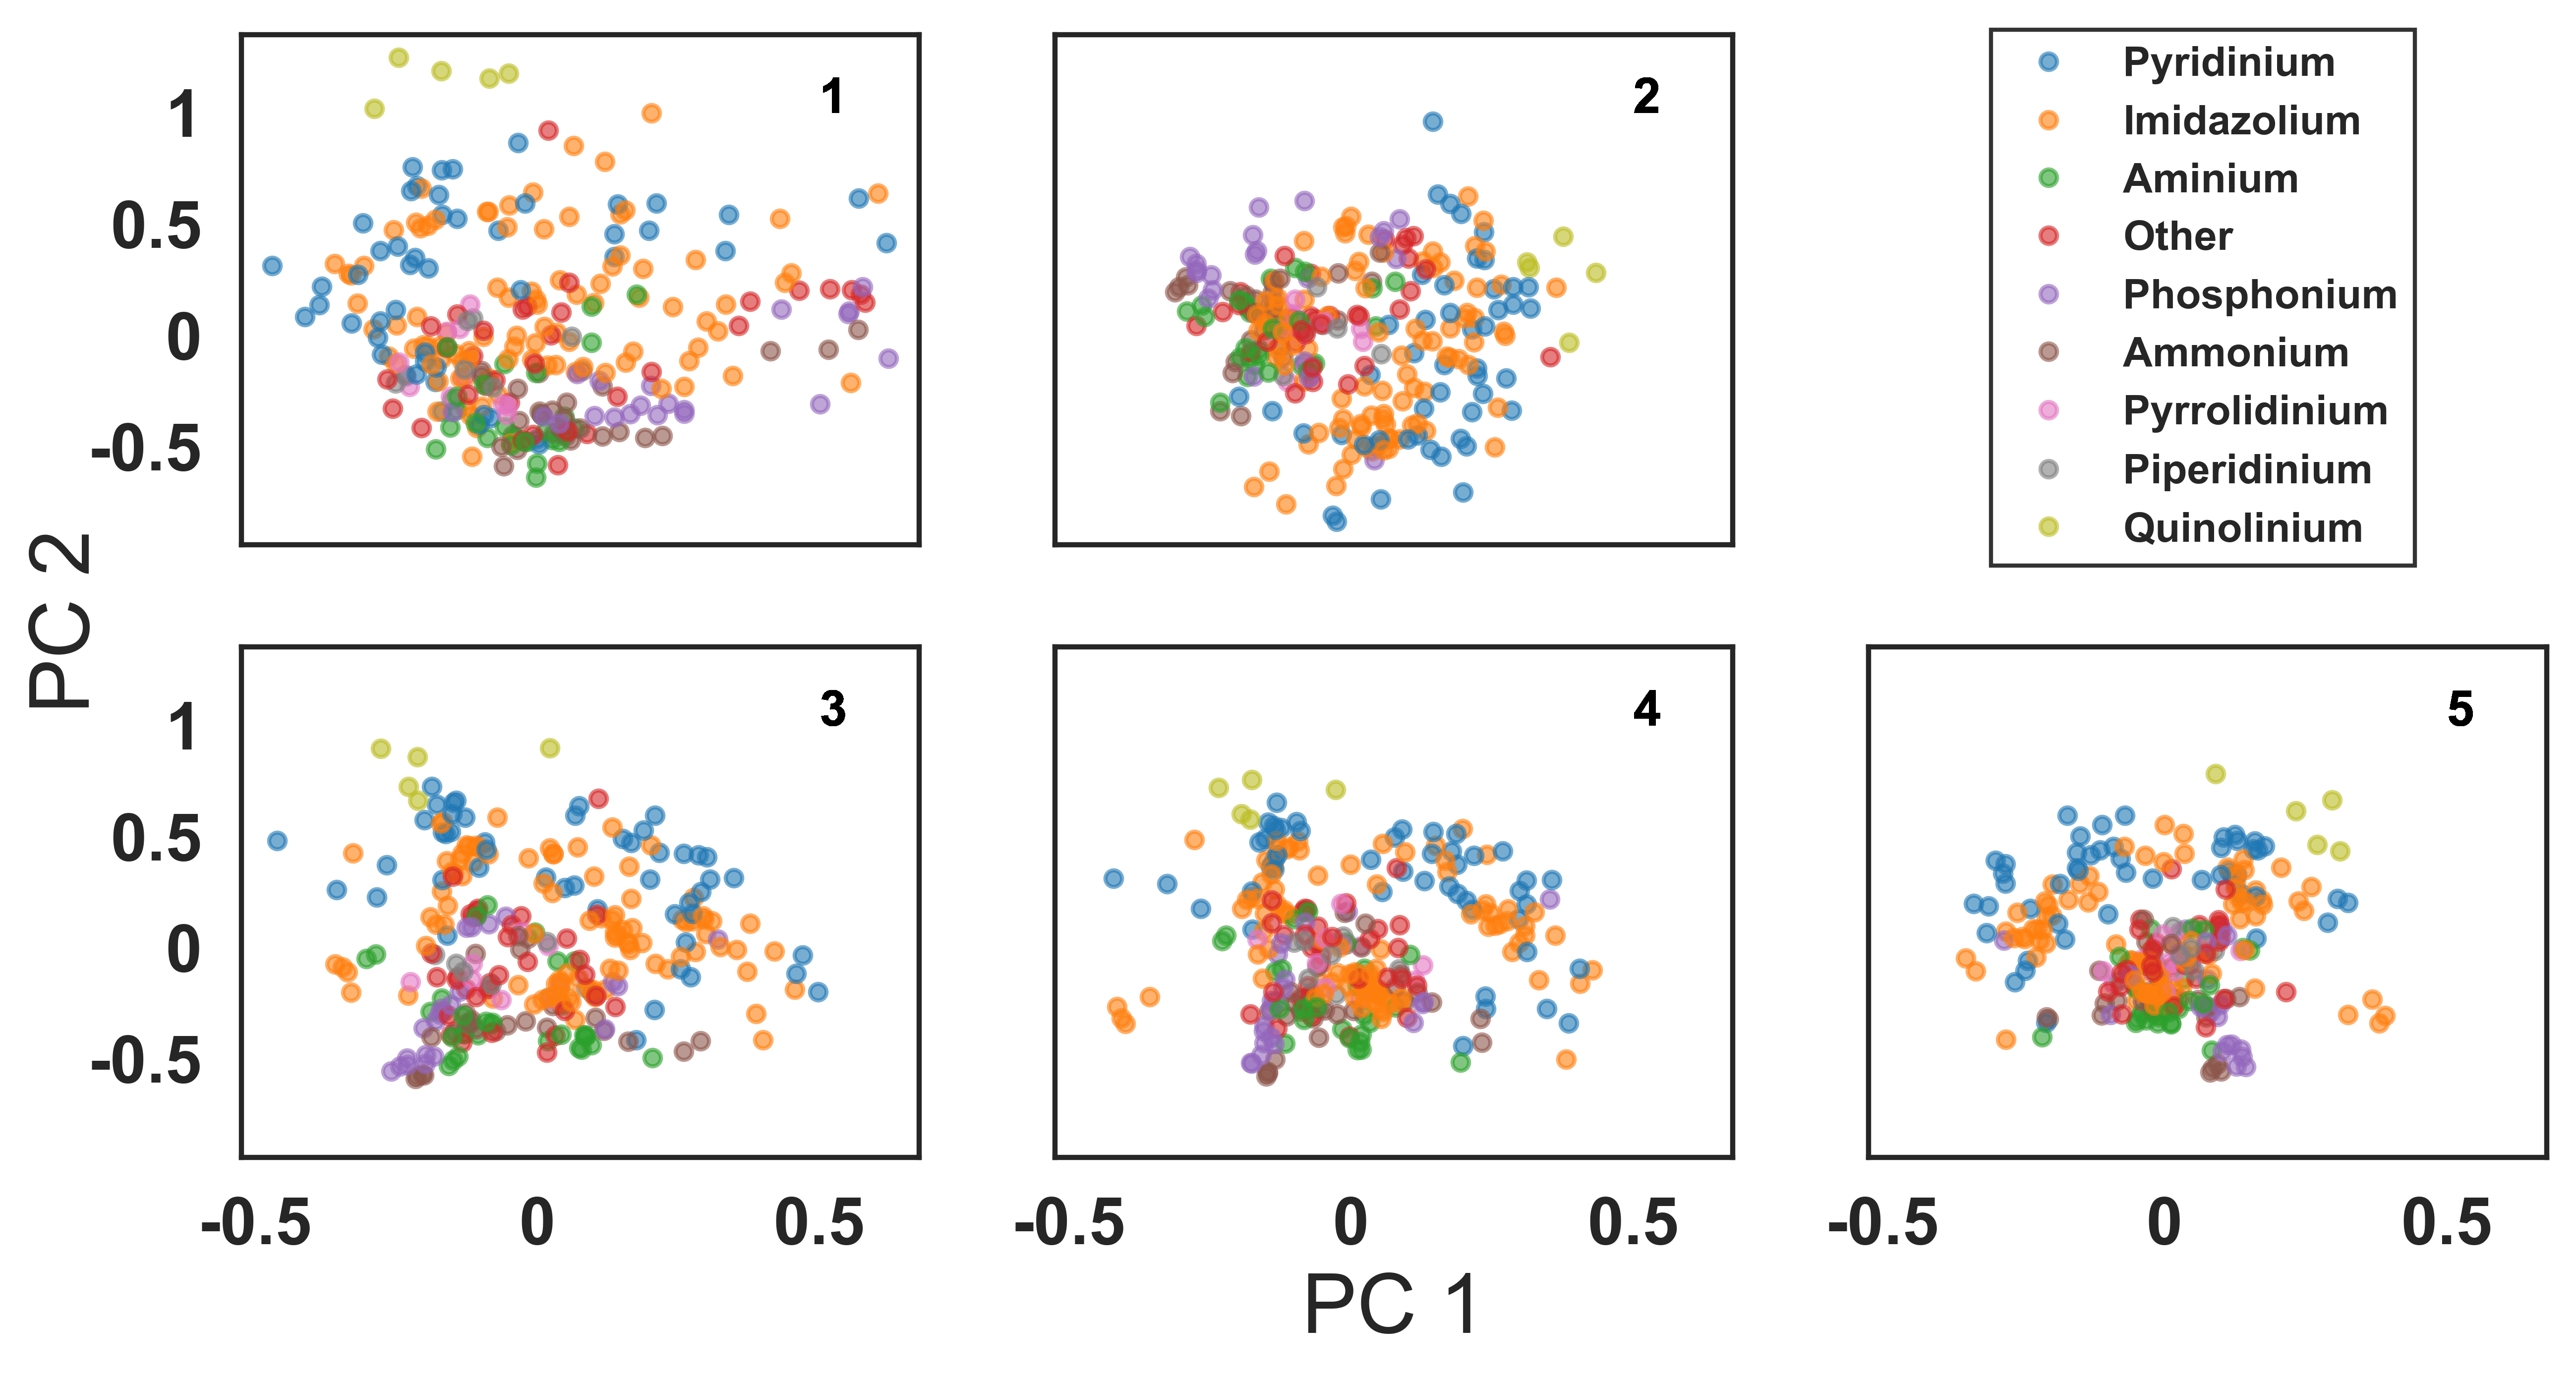

In [58]:
%config InlineBackend.figure_format = 'retina'
cation_embeddings_final = np.load('../data/latent_arrays/cation_embeddings_final.npy')
import random
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
# rcParams['lines.linewidth'] = 0.003
#rcParams["legend.fancybox"] = True




from collections import OrderedDict
with plt.style.context('seaborn-ticks'):
    fig, axs = plt.subplots(2, 3, figsize=(10,5), sharey=True, sharex=True, dpi=300)
    axs = axs.ravel()
    for model in range(5):
        z = cation_embeddings_final[model]
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(z)
        #fig = plt.figure(figsize=(7,7), dpi=300)
        #axs = fig.add_subplot(2, 3, model+1)

        for i in range(len(categories)):
            x = pcs[i,0]
            y = pcs[i,1]
            if model < 2:
                axs[model].plot(x, y, linestyle='', marker='.', alpha = 0.6,
                         color=coldic[categories[i]], markersize=8, label=categories[i])
                axs[model].text(1, 1, '{}'.format(model+1), {'color': 'black', 'fontsize': 12})
                
                if model == 1:
                    h1, l1 = axs[1].get_legend_handles_labels()
                    by_label = OrderedDict(zip(l1, h1))
#                     del by_label['start']
#                     del by_label['stop']
              
                    axs[1].legend(by_label.values(), by_label.keys(), fontsize=10, bbox_to_anchor=(1.35,1.05), 
                                  frameon=True, edgecolor = 'black')
            else:
                axs[model+1].plot(x, y, linestyle='', marker='.', alpha = 0.6,
                         color=coldic[categories[i]], markersize=8, label=categories[i])
                
                axs[model+1].text(1, 1, '{}'.format(model+1), {'color': 'black', 'fontsize': 12})
                
                
    axs[2].axis('off')
    label1 = axs[4].set_xlabel('PC 1', fontsize = 20)
    label2 = axs[0].set_ylabel('PC 2', fontsize = 20)

    axs[0].yaxis.set_label_coords(-0.2, -0.15)
    yticks = [-1, -0.5, 0, 0.5, 1]
    axs[0].set_yticklabels(yticks, fontsize=16)
    axs[3].set_yticklabels(yticks, fontsize=16)
    axs[3].set_xticklabels(yticks, fontsize=16)
    axs[4].set_xticklabels(yticks, fontsize=16)
    axs[5].set_xticklabels(yticks, fontsize=16)

 
 
    
        
# for model in range(0,2): #plot of training data only
#     z = cation_embeddings_final[model]
#     pca = PCA(n_components=2)
#     pcs = pca.fit_transform(z)
#     for i in range(len(categories)):
#         axs[model].plot(pcs[i,0], 
#                         pcs[i,1],
#                  linestyle='', marker='.', markersize=12,
#                     color=coldic[categories[i]], alpha=1, label=categories[i])
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), fontsize=40, framealpha=10, frameon=True)

In [59]:
fig.savefig('assets/fig3.svg', dpi=300)

##### **Sampling in the latent space**

Models

*purist*
* M1: 250K bootstrap C+
* M2: 1000K bootstrap C+
* M3: 1000K GDB

*transfer*
* M4: M3 + 500K GDB/C+
* M5: M4 + 500K C+

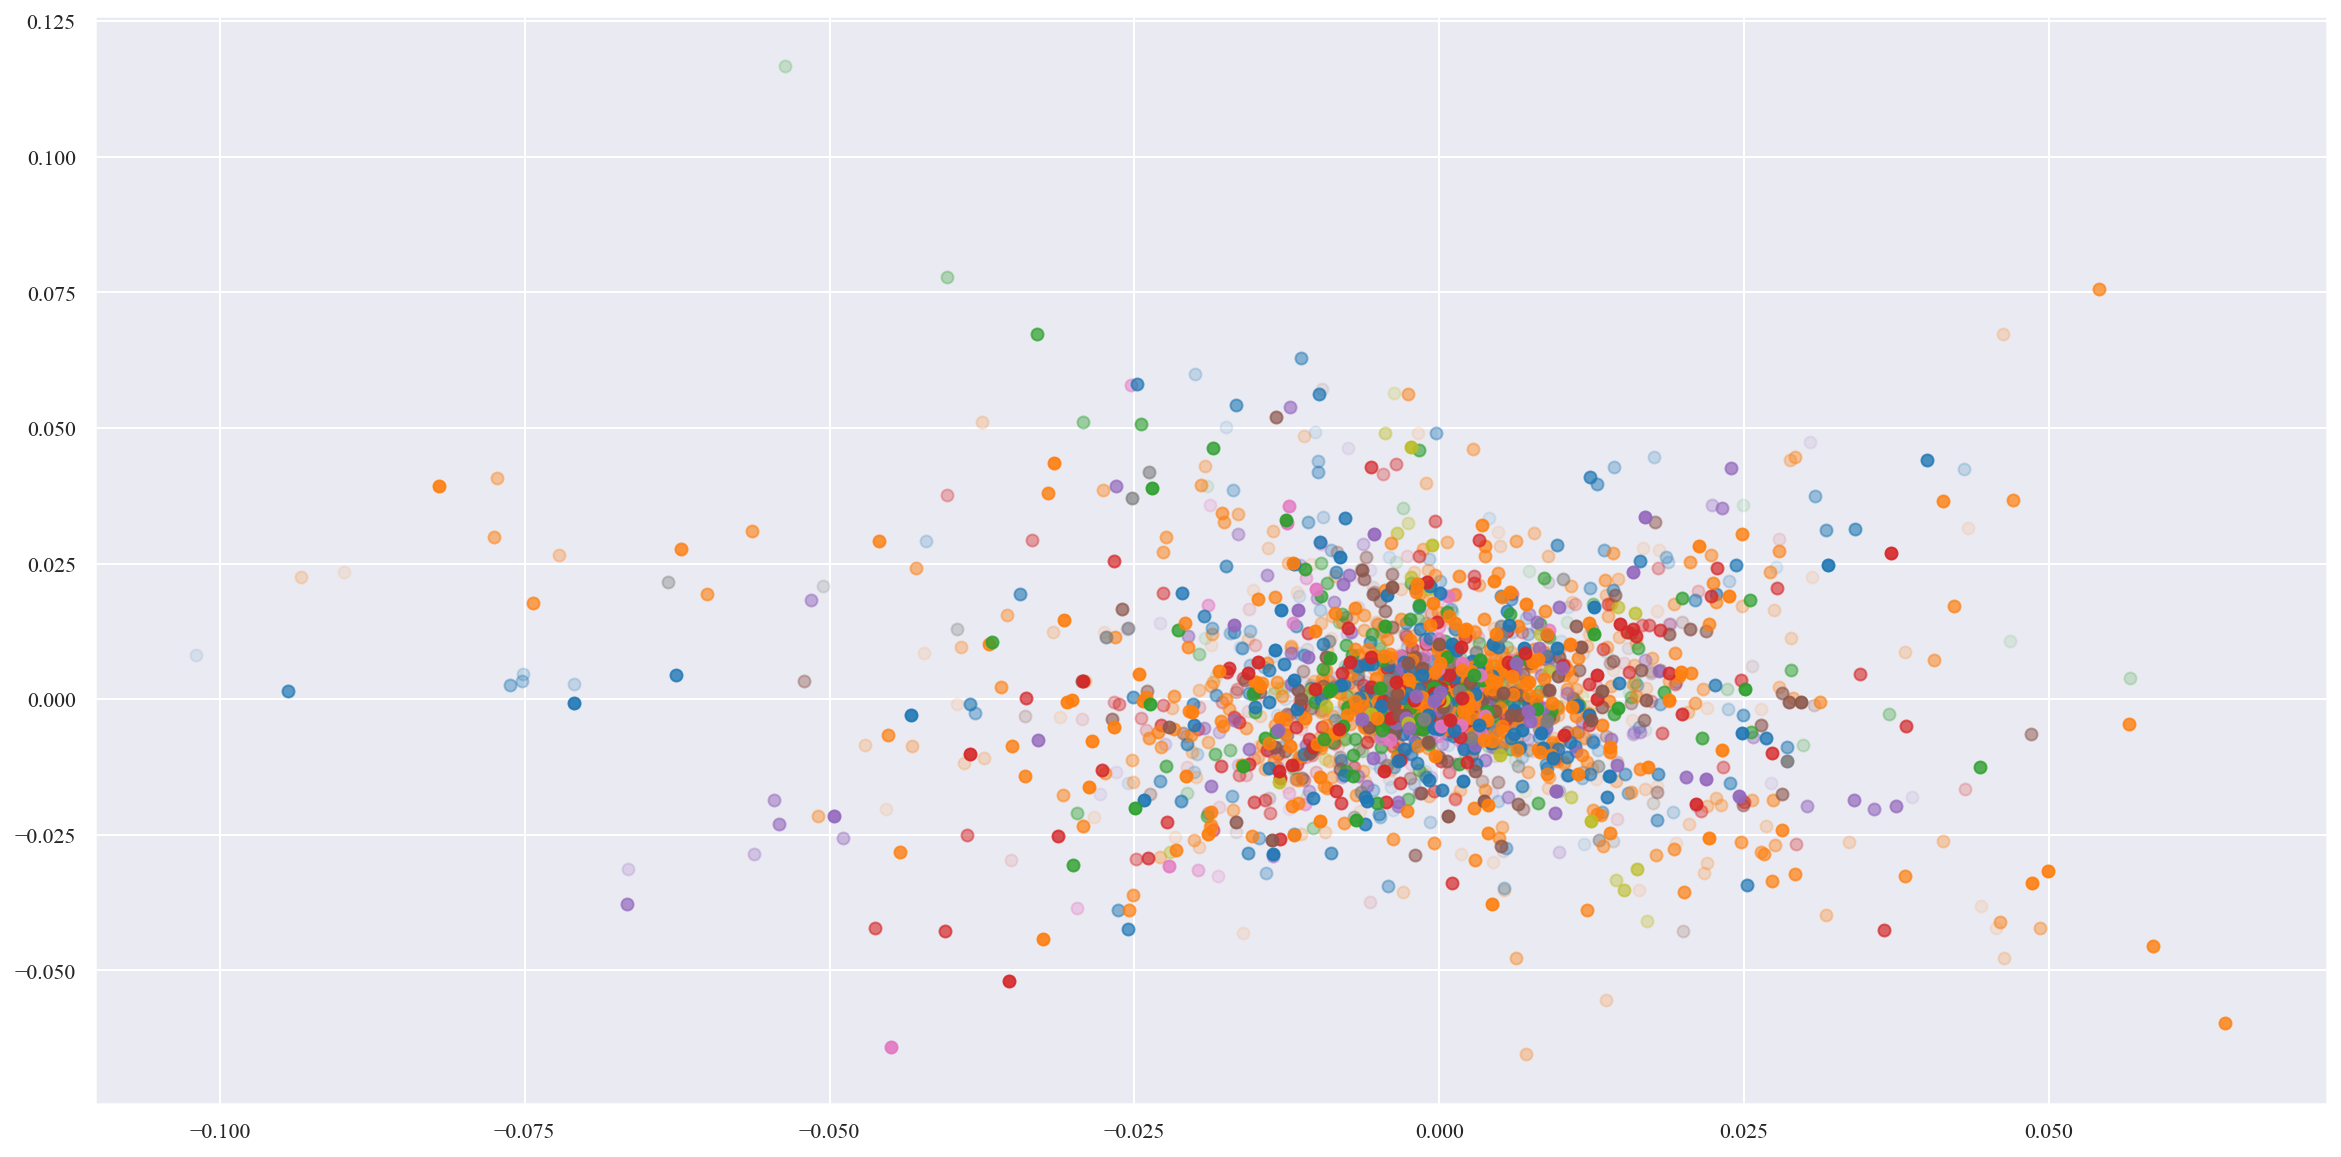

In [10]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
peters_porrige = []
for peter in range(10):
    z = []
    for smi in cations:
        z_i = chemvae.encoder.predict(one_hot(smi, char_to_index))
        z.append(z_i[0])
    z = np.array(z)
    pca = PCA(n_components=2)
    pca.fit_transform(z)
    peters_porrige.append(z)
    for i in range(len(categories)):
        ax1.plot(np.sum(np.dot(pca.components_[0,i],z[i,:])), 
             np.sum(np.dot(pca.components_[1,i],z[i,:])),
            linestyle='', marker='.', color=coldic[categories[i]], markersize=12, label=categories[i], alpha=peter/10)

**we can see the enforced prior in the latent space**

4	 positively charged molecules in M1 w/o C+
4	 positively charged molecules in M2 w/o C+
4	 positively charged molecules in M3 w/o C+
4	 positively charged molecules in M4 w/o C+
4	 positively charged molecules in M5 w/o C+


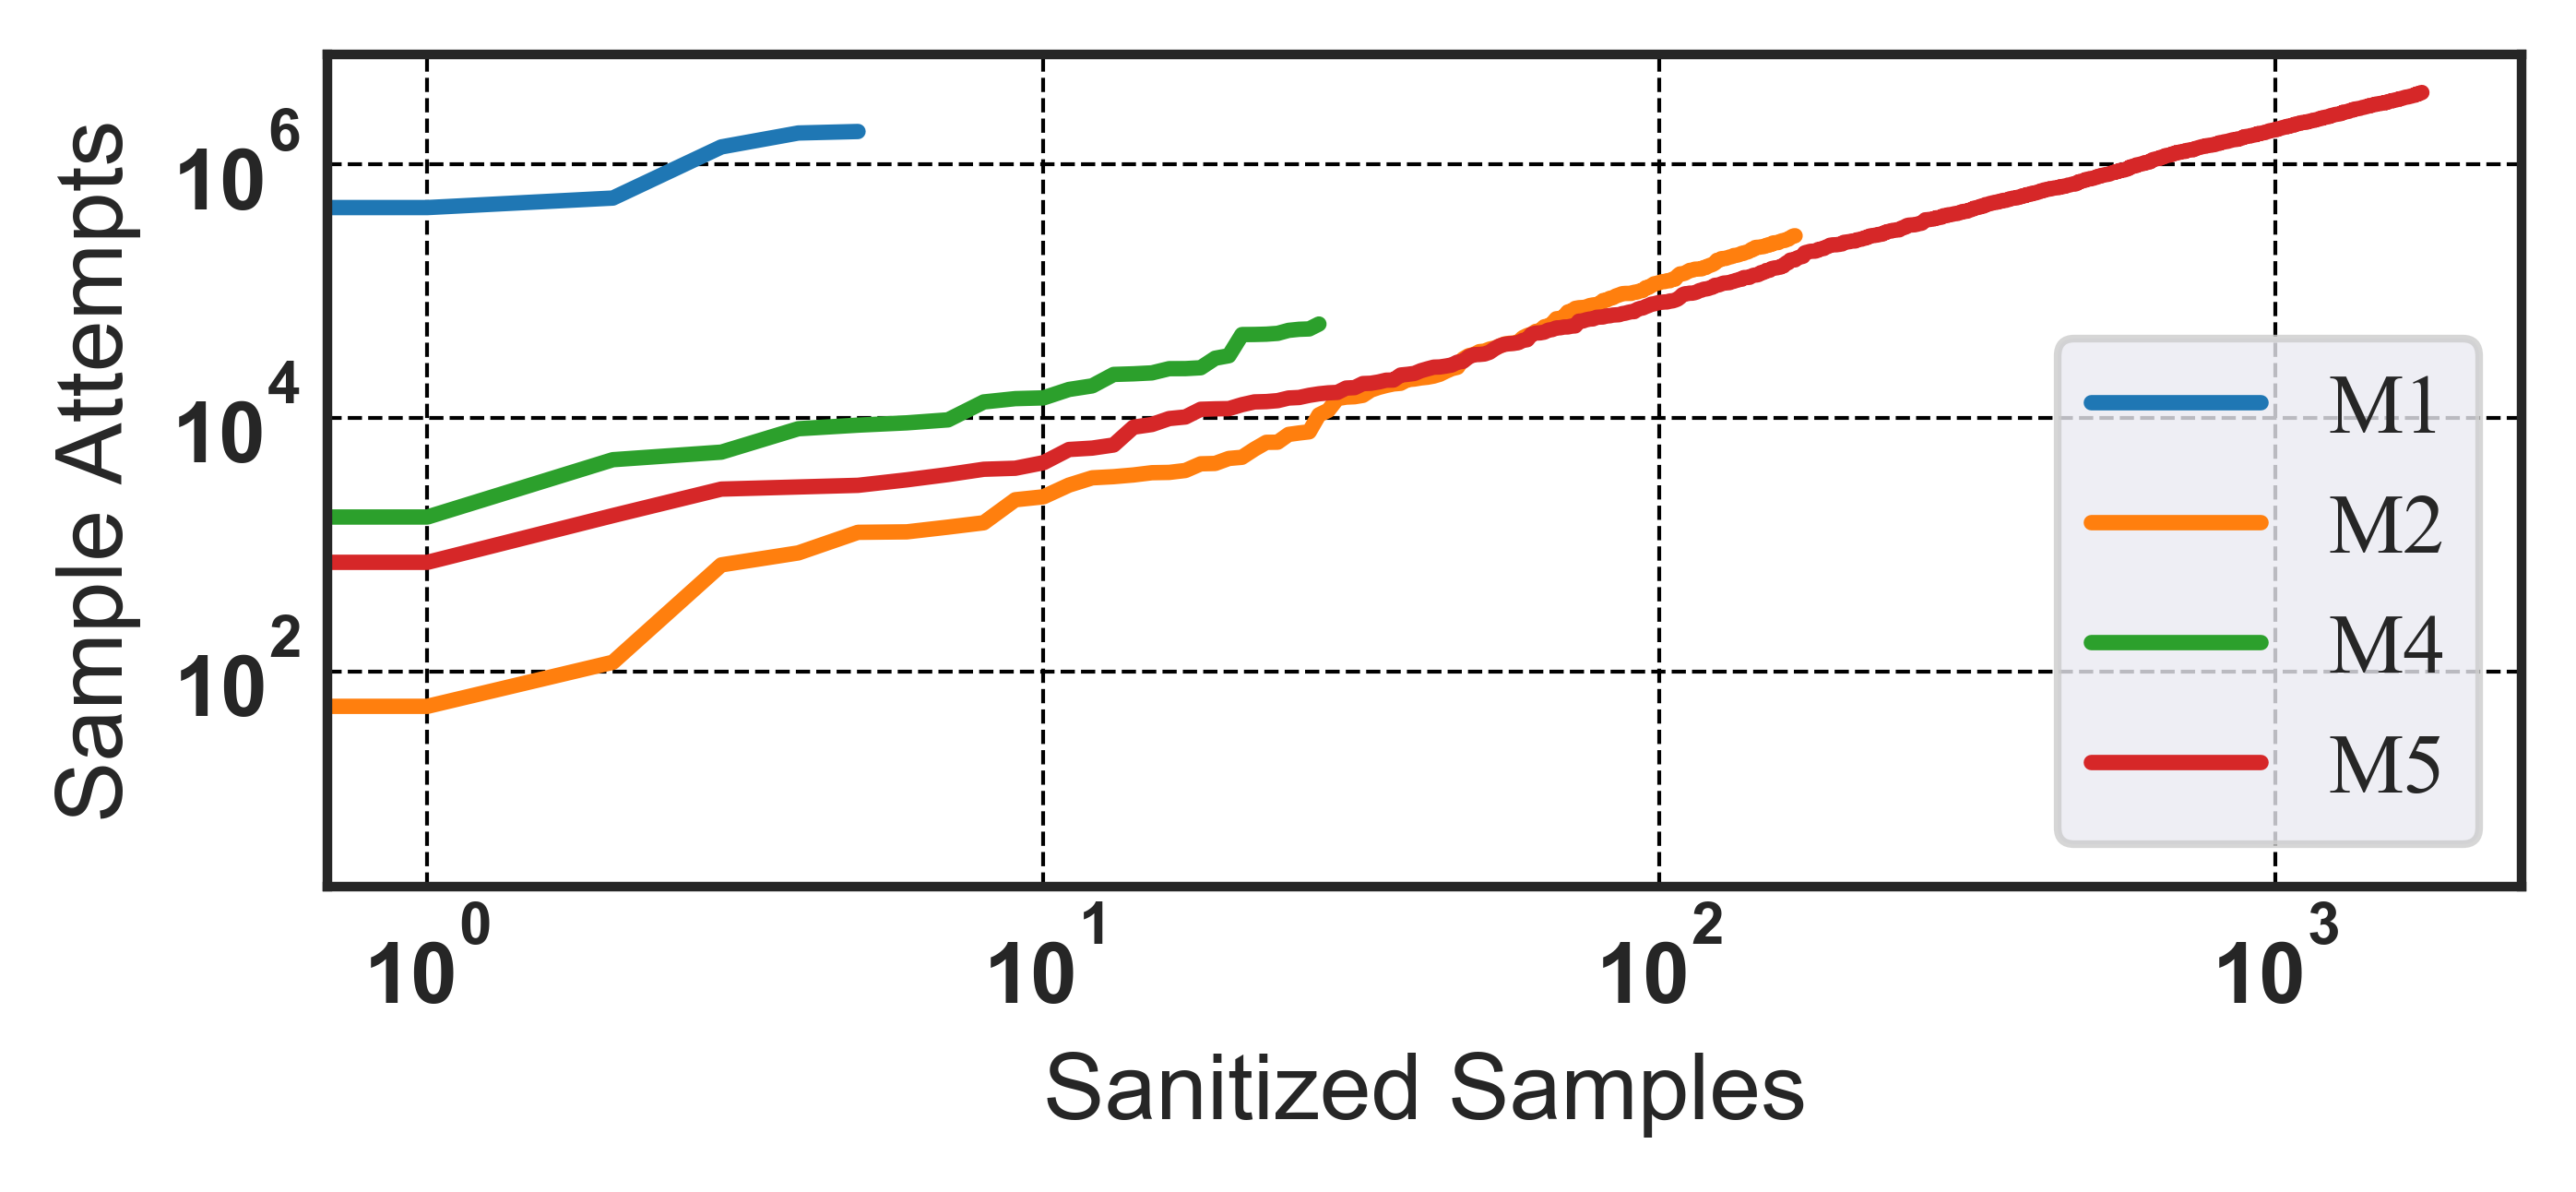

In [11]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = True

ms = [cations[0], 'CCCC[C+]1C=CC(C)=C1C', 'CCCC[C+]1C=CC(CC)=C1', cations[2]]
ms = [Chem.MolFromSmiles(smi) for smi in ms]
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(5,2.5), dpi=300)
    ax = fig.add_subplot(111)
    tab = my_colors()
#     for i, df in enumerate(dfs): #for all returns in dfs
    ###start positive version
    for i, df in enumerate(dfs): #only for (+) mols w/o C+ in dataset
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
        if df.shape[0] == 0:
            continue
        #end positive version
        df['iteration'].plot(label='M{}'.format(i+1), ax=ax, loglog=True, color=next(tab))
    ax.set_ylabel('Sample Attempts')
    ax.set_xlabel('Sanitized Samples')
ax.legend()
sns.set_style('darkgrid', {'legend.frameon':True})
ax.grid(color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()

In [12]:
#fig.savefig('assets/fig1a.svg', bbox_inches='tight', dpi=300)

/Users/prguser/opt/anaconda3/envs/gen_salt/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(-0.6, -0.5, 'Temperature')

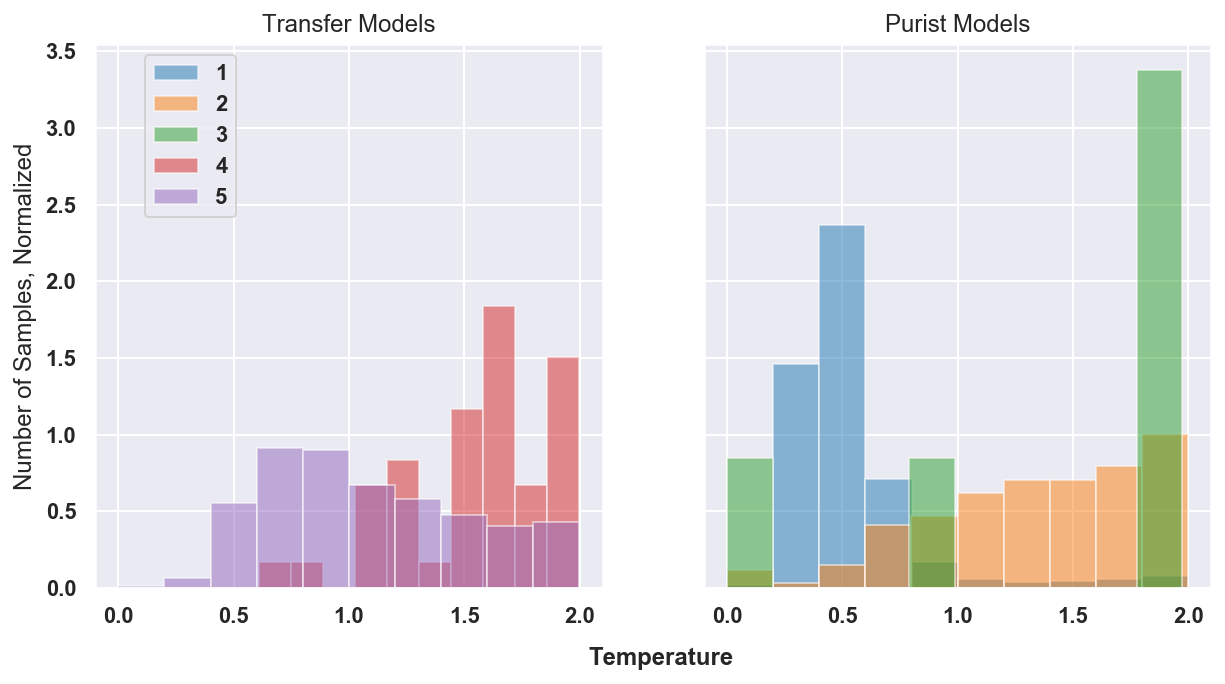

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax2, color=next(tab))
    else:
        df['temperature'].hist(alpha=0.5, label='{}'.format(index+1), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.9,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.6,-0.5,'Temperature',size=12)

In [15]:
#Draw.DrawingOptions.atomLabelFontSize = 
Draw.DrawingOptions.atomLabelFontSize = 20
Draw. DrawingOptions.bondLineWidth = 5

def draw(smiles, size=(300, 300), kekulize=True, wedgeBonds=False, imageType=None, fitImage=False, options=None, **kwargs):
    """
    draw smiles to notebook with RDKit
    
    and without those dumb matplotlib ticks
    
    ¯\_(ツ)_/¯
    
    """
    canvas = Canvas(size)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.Mol(mol.ToBinary())
    Chem.Kekulize(mol)
    AllChem.Compute2DCoords(mol)
    drawer = MolDrawing(canvas=canvas)
    omol = mol
    drawer.AddMol(mol)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    canvas._figure.set_size_inches(float(size[0]) / 100, float(size[1]) / 100)
    canvas._figure
    return canvas._figure

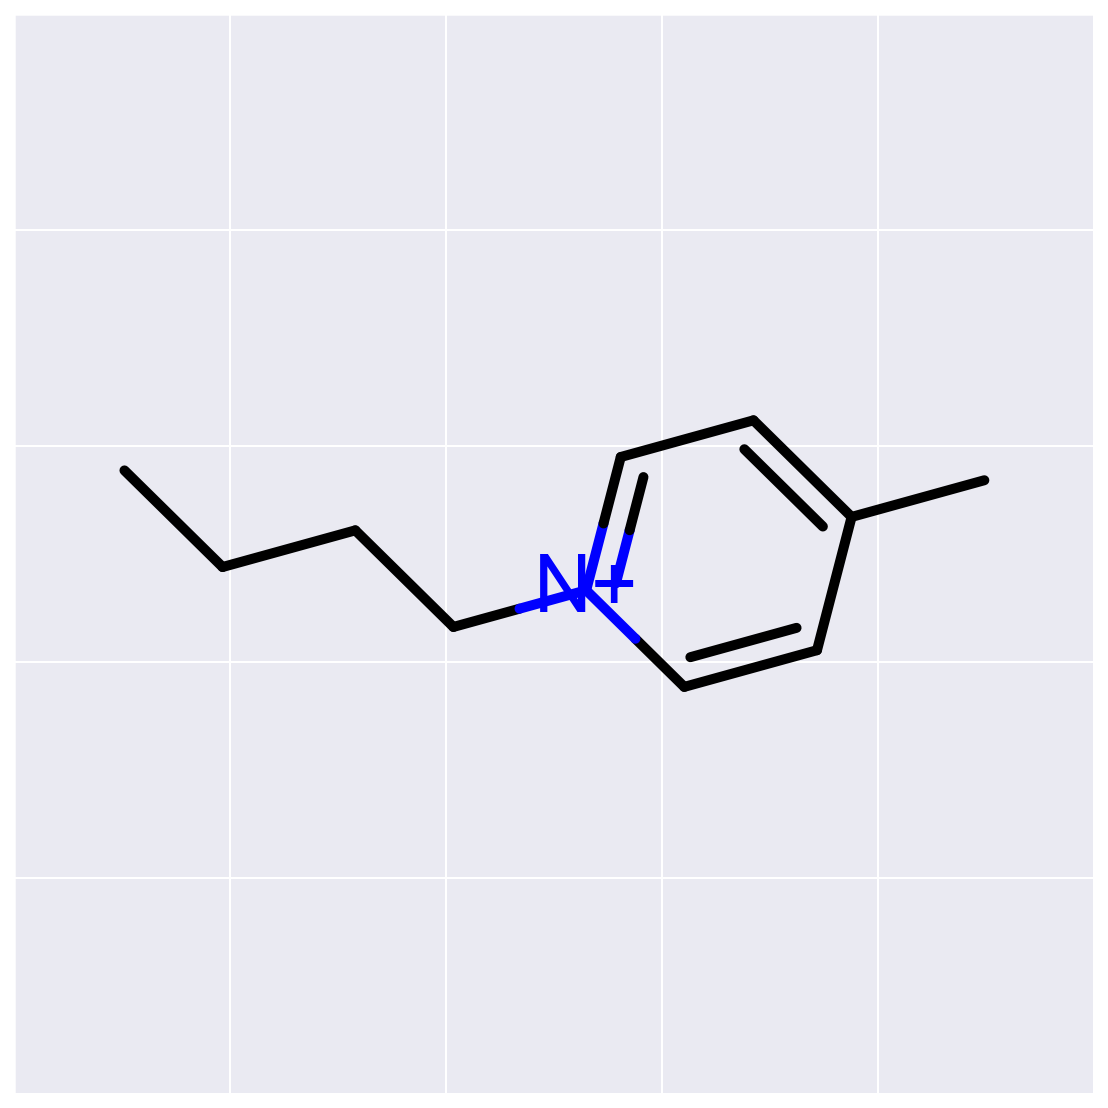

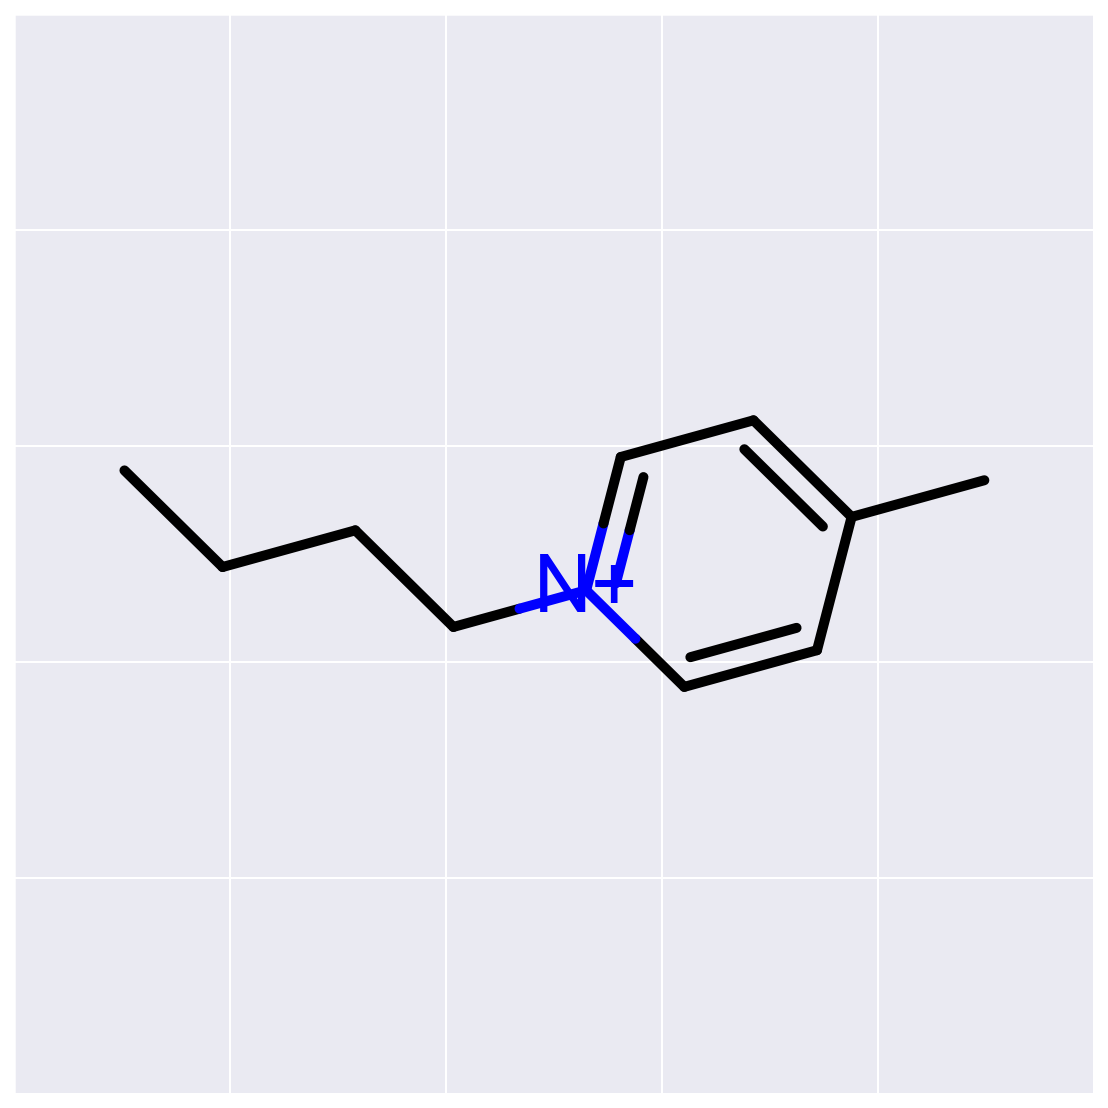

In [16]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
fig = Draw.MolToMPL(seed,size=(300,300))
fig

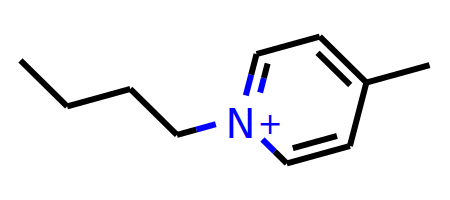

In [17]:
# Generate high quality molecular images
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
d2d = rdMolDraw2D.MolDraw2DSVG(450,200)
#d2d = rdMolDraw2D.MolDraw2DSVG()
d2d.SetFontSize(1)
#d2d.drawOptions().atomLabelFontSize = 24
#d2d.drawOptions().addAtomIndices=True
d2d.drawOptions().bondLineWidth=7
d2d.DrawMolecule(seed)
d2d.FinishDrawing()
imag = SVG(d2d.GetDrawingText())

from cairosvg import svg2svg
svg2svg(bytestring=imag.data,write_to='seed.svg')
SVG(d2d.GetDrawingText())

In [18]:
#img = SVG(moltosvg(seed))
print(type(imag))
from cairosvg import svg2png
svg2svg(bytestring=imag.data,write_to='seed.svg')

<class 'IPython.core.display.SVG'>


In [19]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')], )
print(type(img))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [20]:
seed = Chem.MolFromSmiles('CCCC[n+]1ccc(cc1)C')
for df in dfs:
    daylight = []
    maccs = []
    for mol in df['smiles']:
        ms = [seed, Chem.MolFromSmiles(mol)]
        fps_maccs = [MACCSkeys.GenMACCSKeys(x) for x in ms]
        fps_daylight = [FingerprintMols.FingerprintMol(x) for x in ms]
#         fps = [Chem.rdmolops.RDKFingerprint(x, useHs=False, maxPath=7) for x in ms]
        daylight.append(DataStructs.FingerprintSimilarity(fps_daylight[0],fps_daylight[1]))
        maccs.append(DataStructs.FingerprintSimilarity(fps_maccs[0],fps_maccs[1]))
    df['maccs'] = maccs
    df['daylight'] = daylight

Text(-0.67, -2, 'Daylight Fingerprint Tanimoto Similarity')

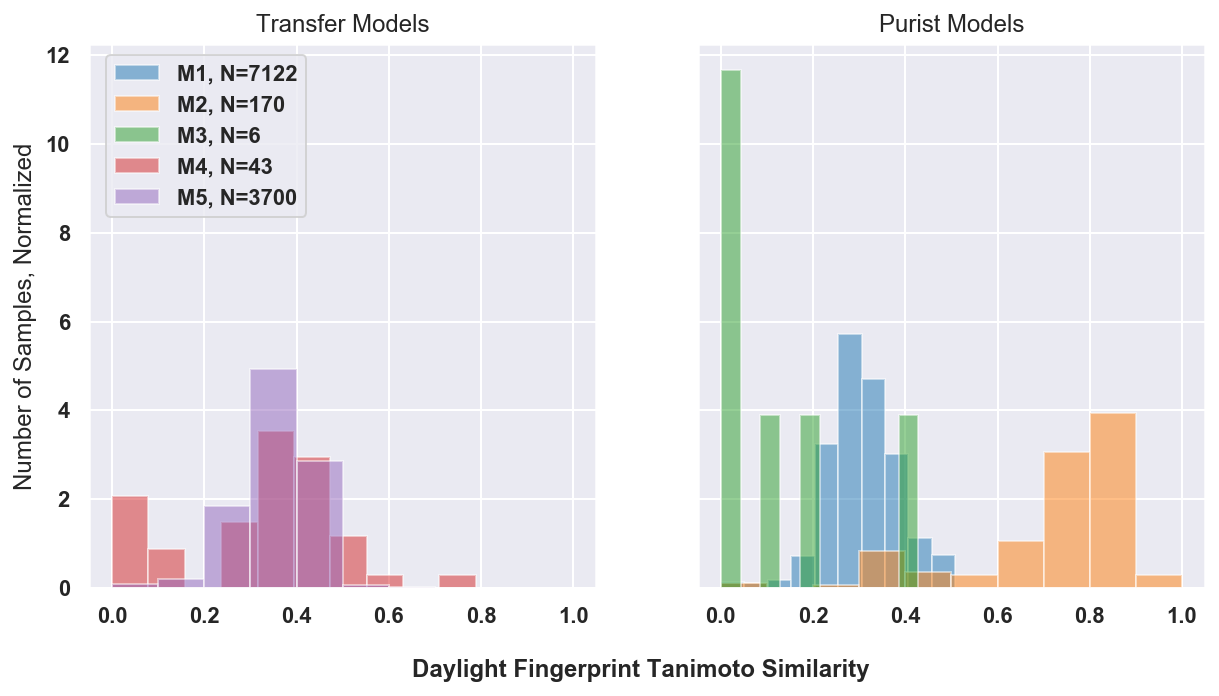

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
tab = my_colors()
for index, df in enumerate(dfs):
    if index < 3:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
    else:
        df['daylight'].hist(alpha=0.5, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(-0.75,1))
ax1.set_ylabel('Number of Samples, Normalized')
ax1.set_title('Transfer Models')
ax2.set_title('Purist Models')
plt.text(-0.67,-2,'Daylight Fingerprint Tanimoto Similarity',size=12)

2	 positively charged molecules in M1 w/o C+
2	 positively charged molecules in M2 w/o C+
2	 positively charged molecules in M3 w/o C+
2	 positively charged molecules in M4 w/o C+
2	 positively charged molecules in M5 w/o C+


/Users/prguser/opt/anaconda3/envs/gen_salt/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


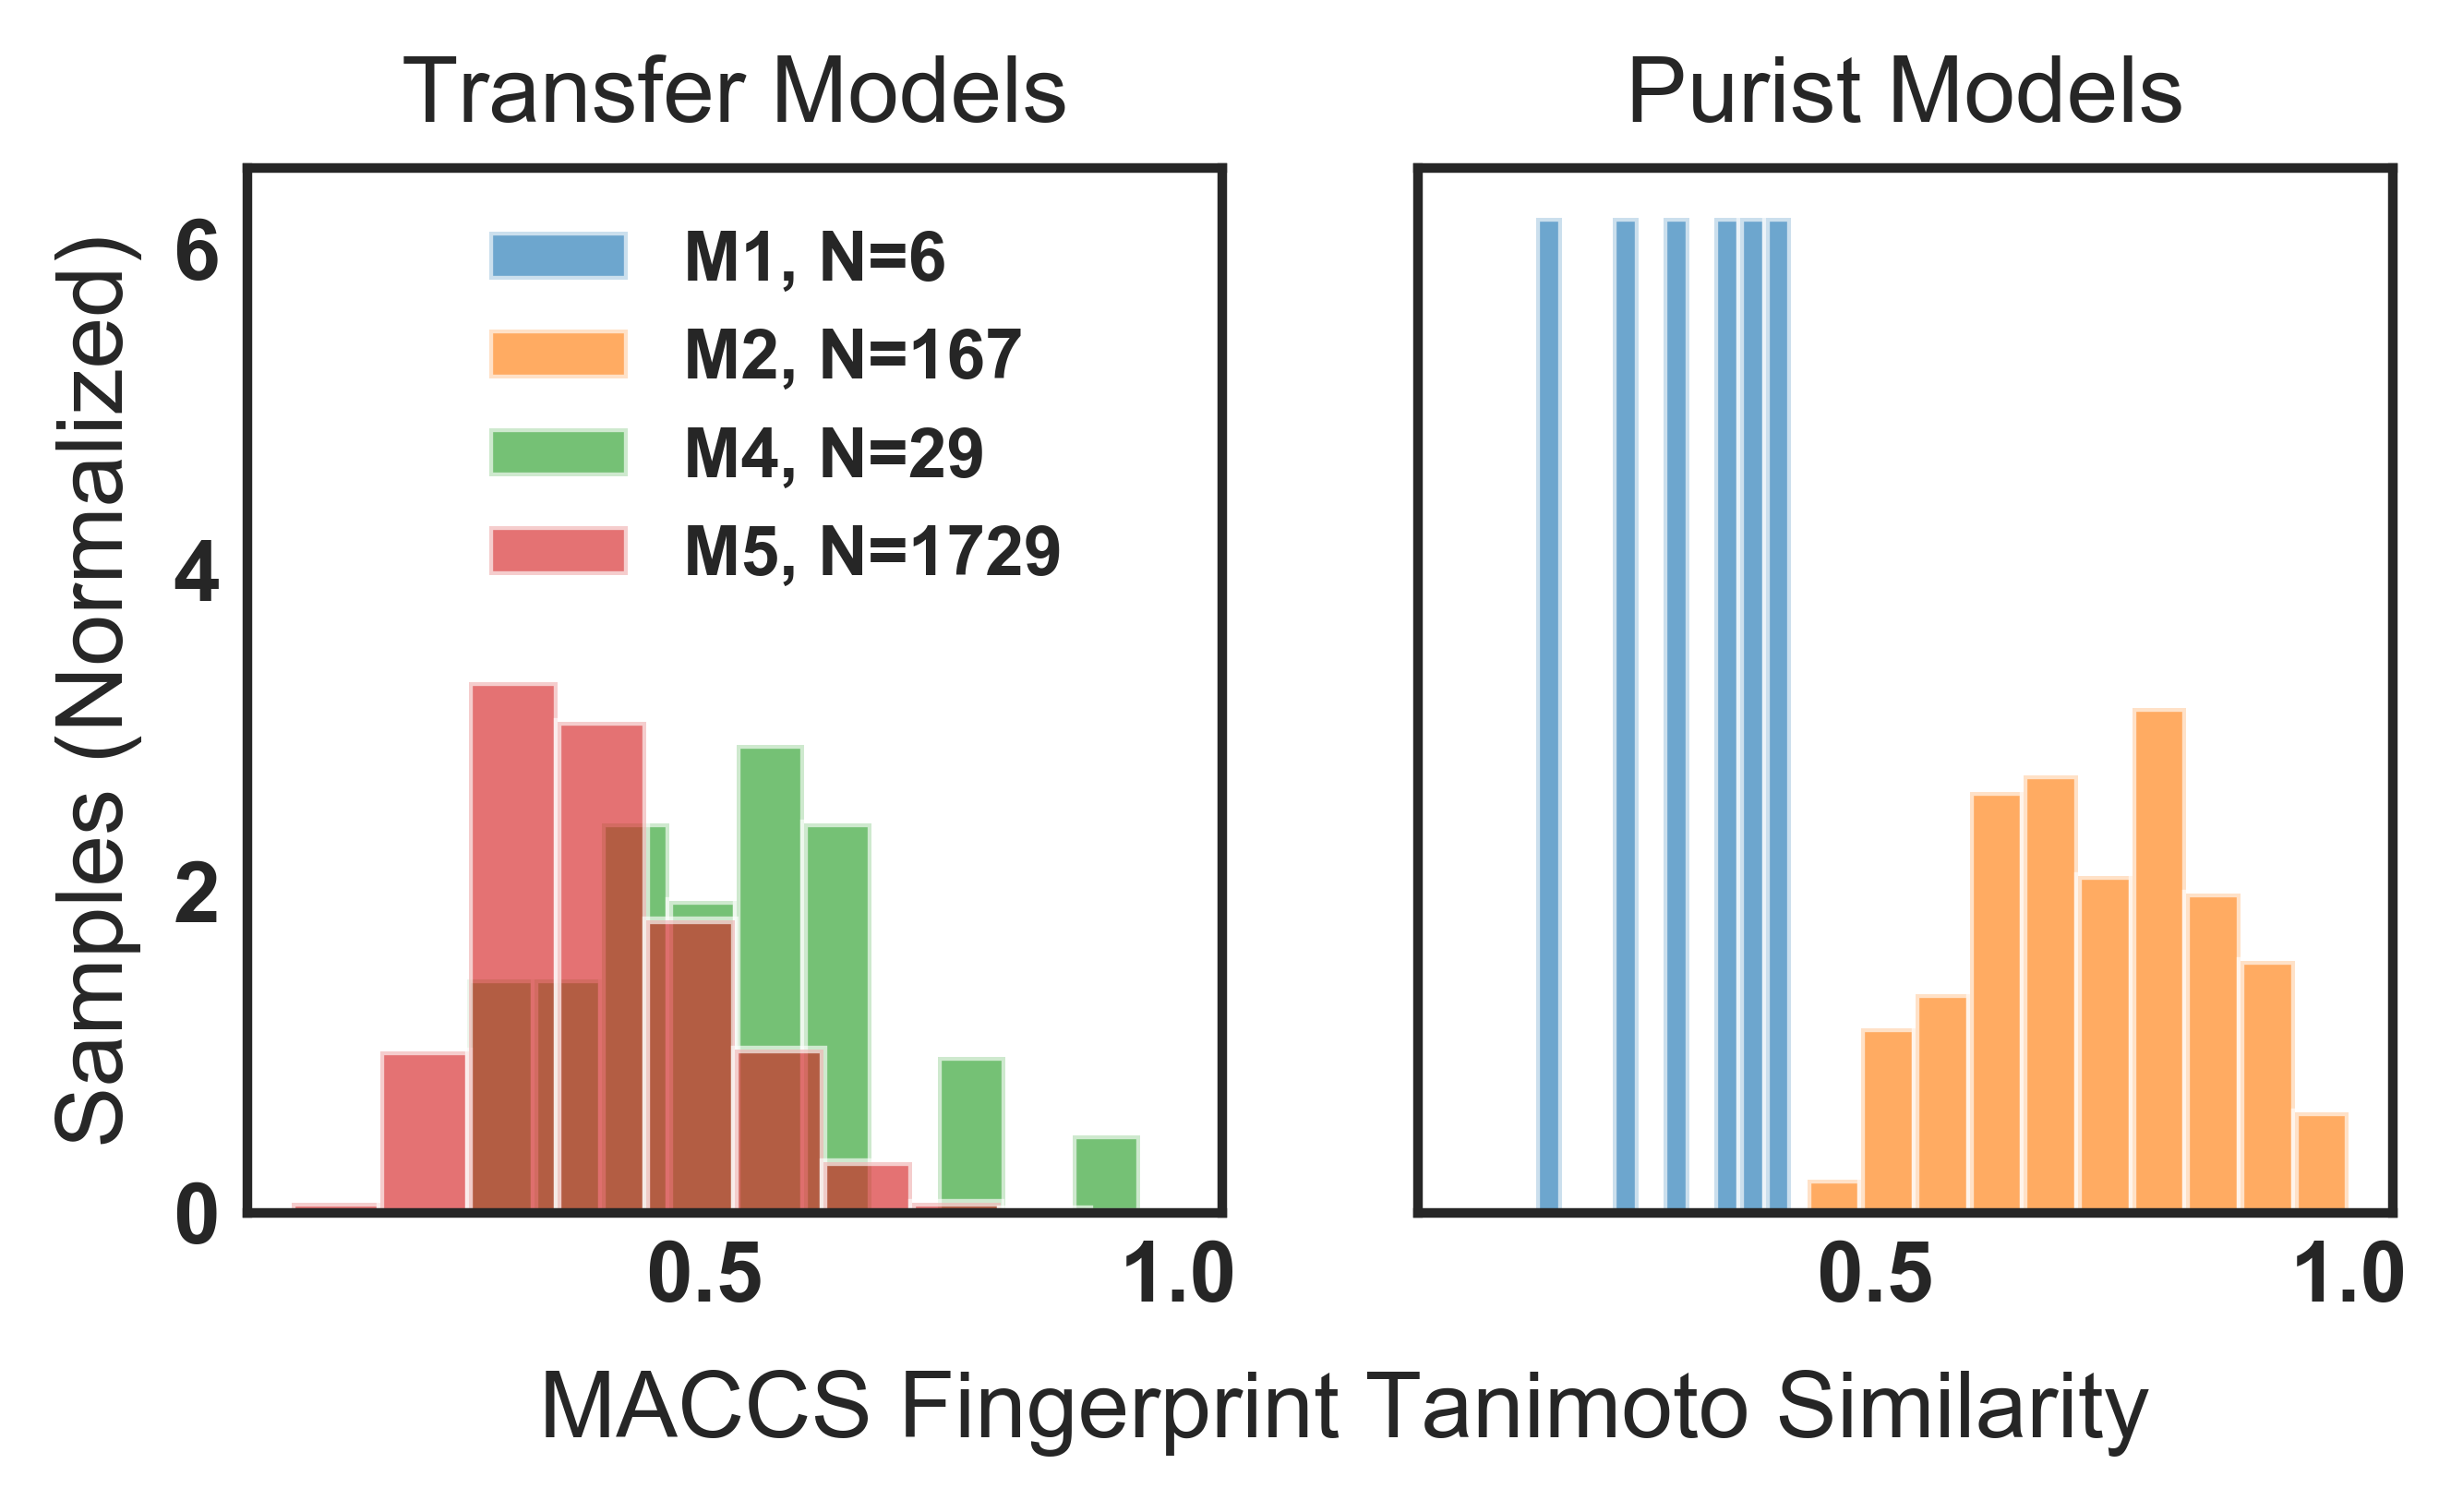

In [23]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = True

with plt.style.context('seaborn-white'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.5), sharey=True, sharex=True, dpi=300)
    tab = my_colors()
        
    for index, df in enumerate(dfs):
        df = df[df['smiles'].str.contains("\+")] 
        df.reset_index(inplace=True)
        print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),index+1))
        if df.shape[0] == 0:
            continue
        if index < 3:
            df['maccs'].hist(alpha=0.65, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax2, color=next(tab))
        else:
            df['maccs'].hist(alpha=0.65, label='M{}, N={}'.format(index+1,df.shape[0]), normed=True, ax=ax1, color=next(tab))
    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax1.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=9, bbox_to_anchor=(-0.3, 1))
    ax1.set_ylabel('Samples (Normalized)', fontsize=12)
    ax1.set_title('Transfer Models')
    ax2.set_title('Purist Models')
    label = ax1.set_xlabel('MACCS Fingerprint Tanimoto Similarity', fontsize = 12)
    ax1.xaxis.set_label_coords(1.125, -0.15)
#     plt.text(-1,-4,'MACCS Fingerprint Tanimoto Similarity',size=12)
    ax1.grid()
    ax2.grid()
#     plt.tight_layout()

In [24]:
# fig.savefig('assets/fig1b.svg', bbox_inches='tight', dpi=300)

**But how many of these structures are relevant?**

In [25]:
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in df['smiles'] if '+' in smi]    
    print('{}\t positively charged molecules in M{}'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [smi for smi in df['smiles'] if '+' in smi]    
    ms = [smi for smi in ms if 'C+' not in smi]
    ms = [smi for smi in ms if 'c+' not in smi]
    print('{}\t positively charged molecules in M{} w/o C+'.format(len(ms),i+1))
print('')
for i, df in enumerate(dfs):
    ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df5, df, how='inner', on='smiles')['smiles']]
    print('{}\t structures shared by M5 and M{}'.format(len(ms),i+1))

6	 positively charged molecules in M1
167	 positively charged molecules in M2
0	 positively charged molecules in M3
29	 positively charged molecules in M4
1729	 positively charged molecules in M5

0	 positively charged molecules in M1 w/o C+
167	 positively charged molecules in M2 w/o C+
0	 positively charged molecules in M3 w/o C+
28	 positively charged molecules in M4 w/o C+
807	 positively charged molecules in M5 w/o C+

94	 structures shared by M5 and M1
9	 structures shared by M5 and M2
4	 structures shared by M5 and M3
11	 structures shared by M5 and M4
3700	 structures shared by M5 and M5


In [26]:
names = ['heat capacity', 'density', 'viscosity', 'thermal conductivity']
epochs = ['no qspr', '10 epoch', '30 epoch', '100 epoch']
dff = pd.read_csv('../data/structure_search_results/property_search_results')
dff.head()

prop   epochs  Unnamed: 2  \
0  heat capacity  no qspr           0   
1  heat capacity  no qspr           1   
2  heat capacity  no qspr           2   
3  heat capacity  no qspr           3   
4  heat capacity  no qspr           4   

                                            ani seed  attempts  \
0           C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F       224   
1  CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]       228   
2                             C([C@@H](C(=O)[O-])N)S       268   
3  CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]       415   
4  CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]       562   

                                  candidate  \
0  CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCNCCCCC   
1  CCCCCCCCCCPCCC[P+](CCCCCC)(CCCCCC)CCCCCC   
2  CCCCCCCCCCNCCC[P+](CCCCCC)(CCCCCC)CCCCCC   
3             CCCCCCCCOCCCCCCCn1cc[n+](C)c1   
4                   CCCC[P+](CCC)(CCCC)CCCC   

                                     cat seed   rdkit qspr  rdkit-md qspr  \
0  C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC  1172.270020    1155.380005   
1  C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC  1482.560059    1475.030029   
2  C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC  1220.020020    1229.900024   
3               CCCCCCCCCCCCCCCCn1cc[n+](c1)C  1064.920044     971.559998   
4                    CCCC[P+](CCCC)(CCCC)CCCC  1202.859985     974.409973   

                                                salt  temperature  vae qspr  
0  CCCCCC[P+](CCCCCC)(CCCCCC)CCCCCCCCNCCCCC.C(F)(...     1.272694  0.947480  
1  CCCCCCCCCCPCCC[P+](CCCCCC)(CCCCCC)CCCCCC.CCCCC...     1.259403  1.039302  
2  CCCCCCCCCCNCCC[P+](CCCCCC)(CCCCCC)CCCCCC.C([C@...     1.412673  0.950409  
3  CCCCCCCCOCCCCCCCn1cc[n+](C)c1.CCCCC(CC)COC(=O)...     1.805683  0.921733  
4  CCCC[P+](CCC)(CCCC)CCCC.CCCCC(CC)COC(=O)CC(C(=...     1.719265  0.913552

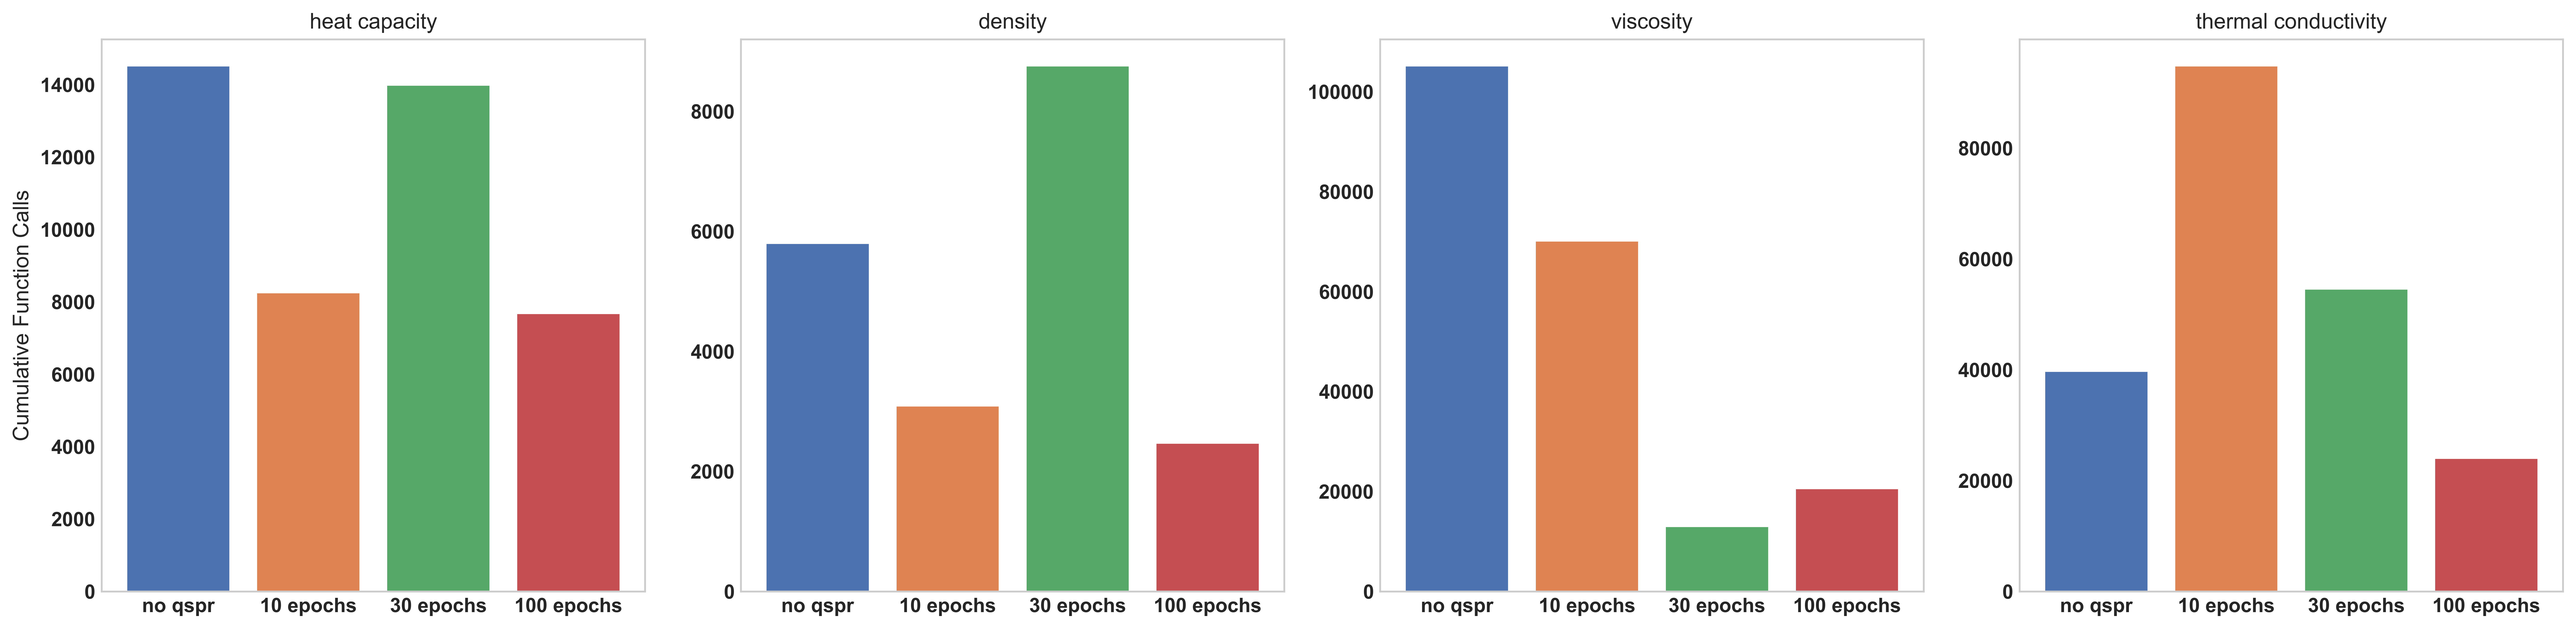

In [27]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1,4, figsize=(20,5), dpi=300, sharey=False)
    for index, dfl in enumerate(dff['prop'].unique()):
        df = dff[dff['prop'] == dfl]
        ax[index].bar(['no qspr'], df[df['epochs'] == 'no qspr']['attempts'], label='no qspr')
        ax[index].bar(['10 epochs'], df[df['epochs'] == '10 epoch']['attempts'], label='10 epochs')
        ax[index].bar(['30 epochs'], df[df['epochs'] == '30 epoch']['attempts'], label='30 epochs')
        ax[index].bar(['100 epochs'], df[df['epochs'] == '100 epoch']['attempts'], label='100 epochs')
        ax[index].set_title('{}'.format(names[index]))
        ax[index].grid()
        if index == 0:
            ax[index].set_ylabel('Cumulative Function Calls')
        
    plt.tight_layout()

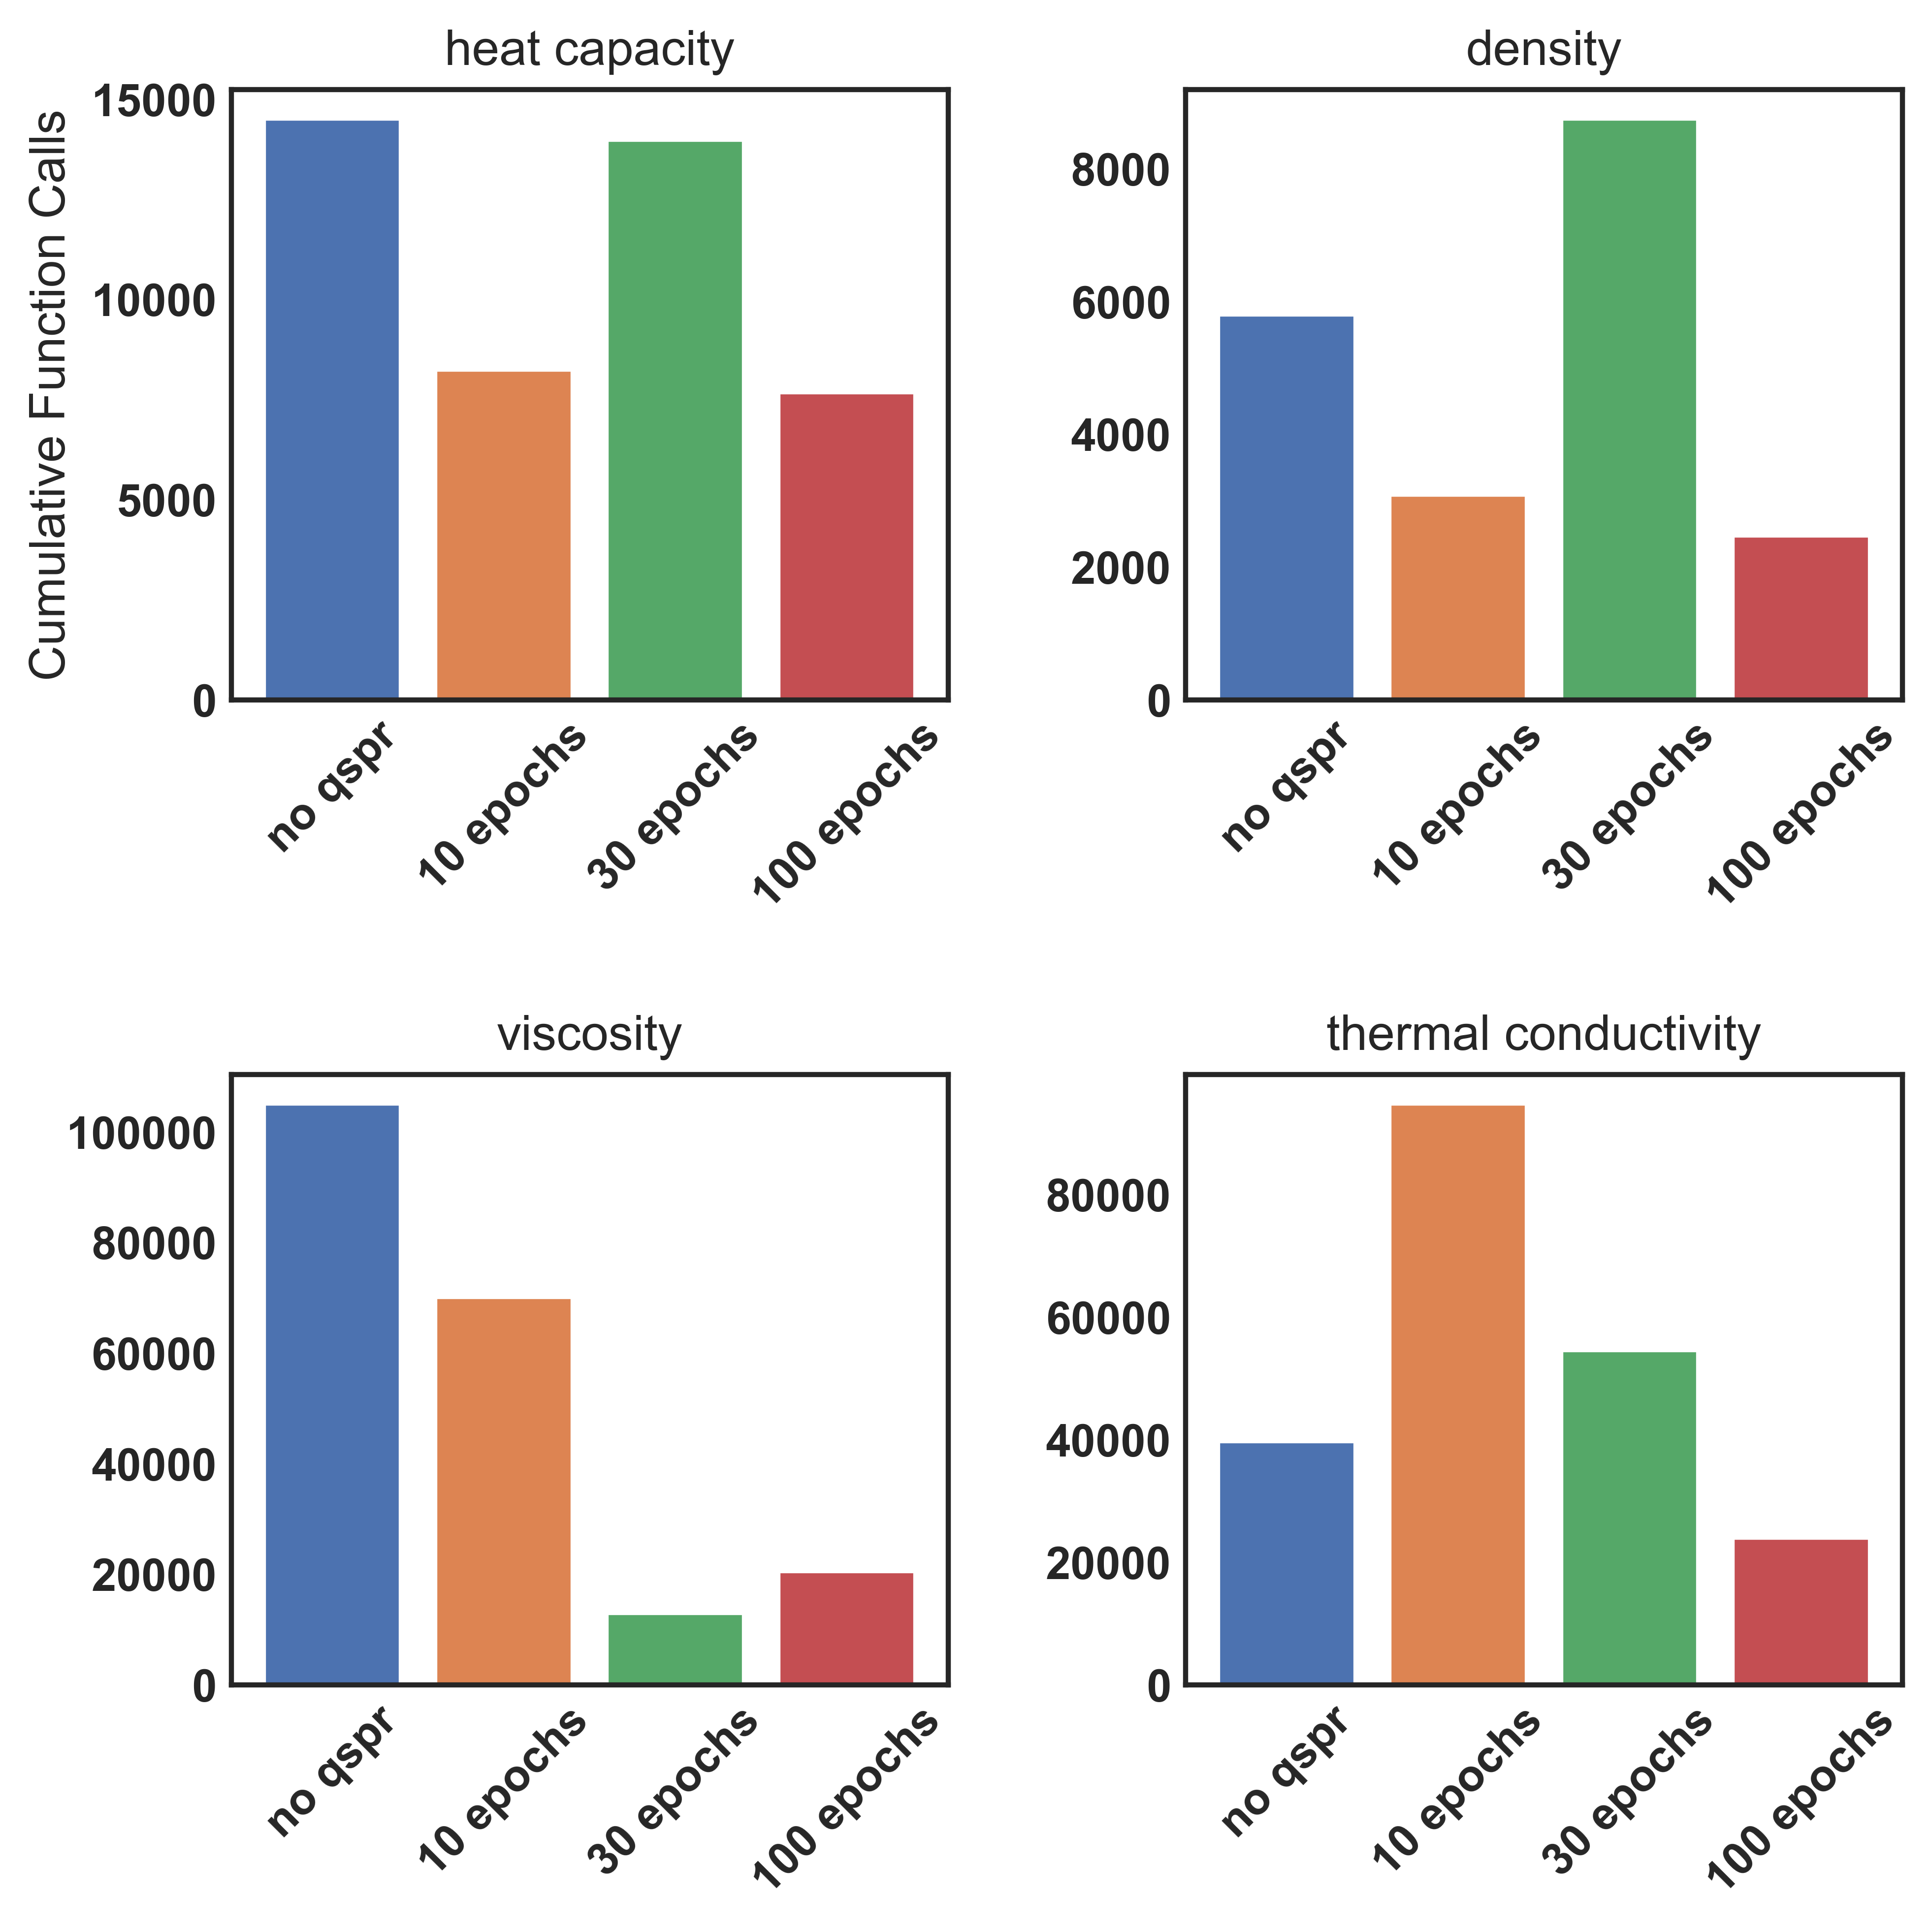

In [28]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = True

with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(2,2, figsize=(7,7), dpi=300, sharey=False)
    
    index = 0
    for index1 in range(2):
        for index2 in range(2):
            
            
            df = dff[dff['prop'] == dff['prop'].unique()[index]]
            ax[index1][index2].bar(['no qspr'], df[df['epochs'] == 'no qspr']['attempts'], label='no qspr')
            ax[index1][index2].bar(['10 epochs'], df[df['epochs'] == '10 epoch']['attempts'], label='10 epochs')
            ax[index1][index2].bar(['30 epochs'], df[df['epochs'] == '30 epoch']['attempts'], label='30 epochs')
            ax[index1][index2].bar(['100 epochs'], df[df['epochs'] == '100 epoch']['attempts'], label='100 epochs')
            ax[index1][index2].set_title('{}'.format(names[index]))
            #ax[index1][index2].grid()
            if index == 0:
                ax[index1][index2].set_ylabel('Cumulative Function Calls')
            plt.setp( ax[index1][index2].xaxis.get_majorticklabels(), rotation=45 )
            index += 1
    plt.tight_layout()


In [28]:
# fig.savefig('assets/fig5.svg', bbox_inches='tight', dpi=300)

In [30]:
import os
histories = []
for root, dirs, files in os.walk("../models/histories"):  
    for filename in files:
        if 'history' in filename:
            if 'gen' in filename:
                if 'GDB17_mix_pure' in filename:
                    histories.append(filename)
histories.sort()
print(histories)

['history_gen1_2mol_1mil_GDB17_mix_pure.json', 'history_gen2_2mol_1mil_GDB17_mix_pure.json', 'history_gen3_2mol_1mil_GDB17_mix_pure.json']


In [31]:
# histories = ['GEN1.h5', 'GEN2.h5', 'GEN3.h5']

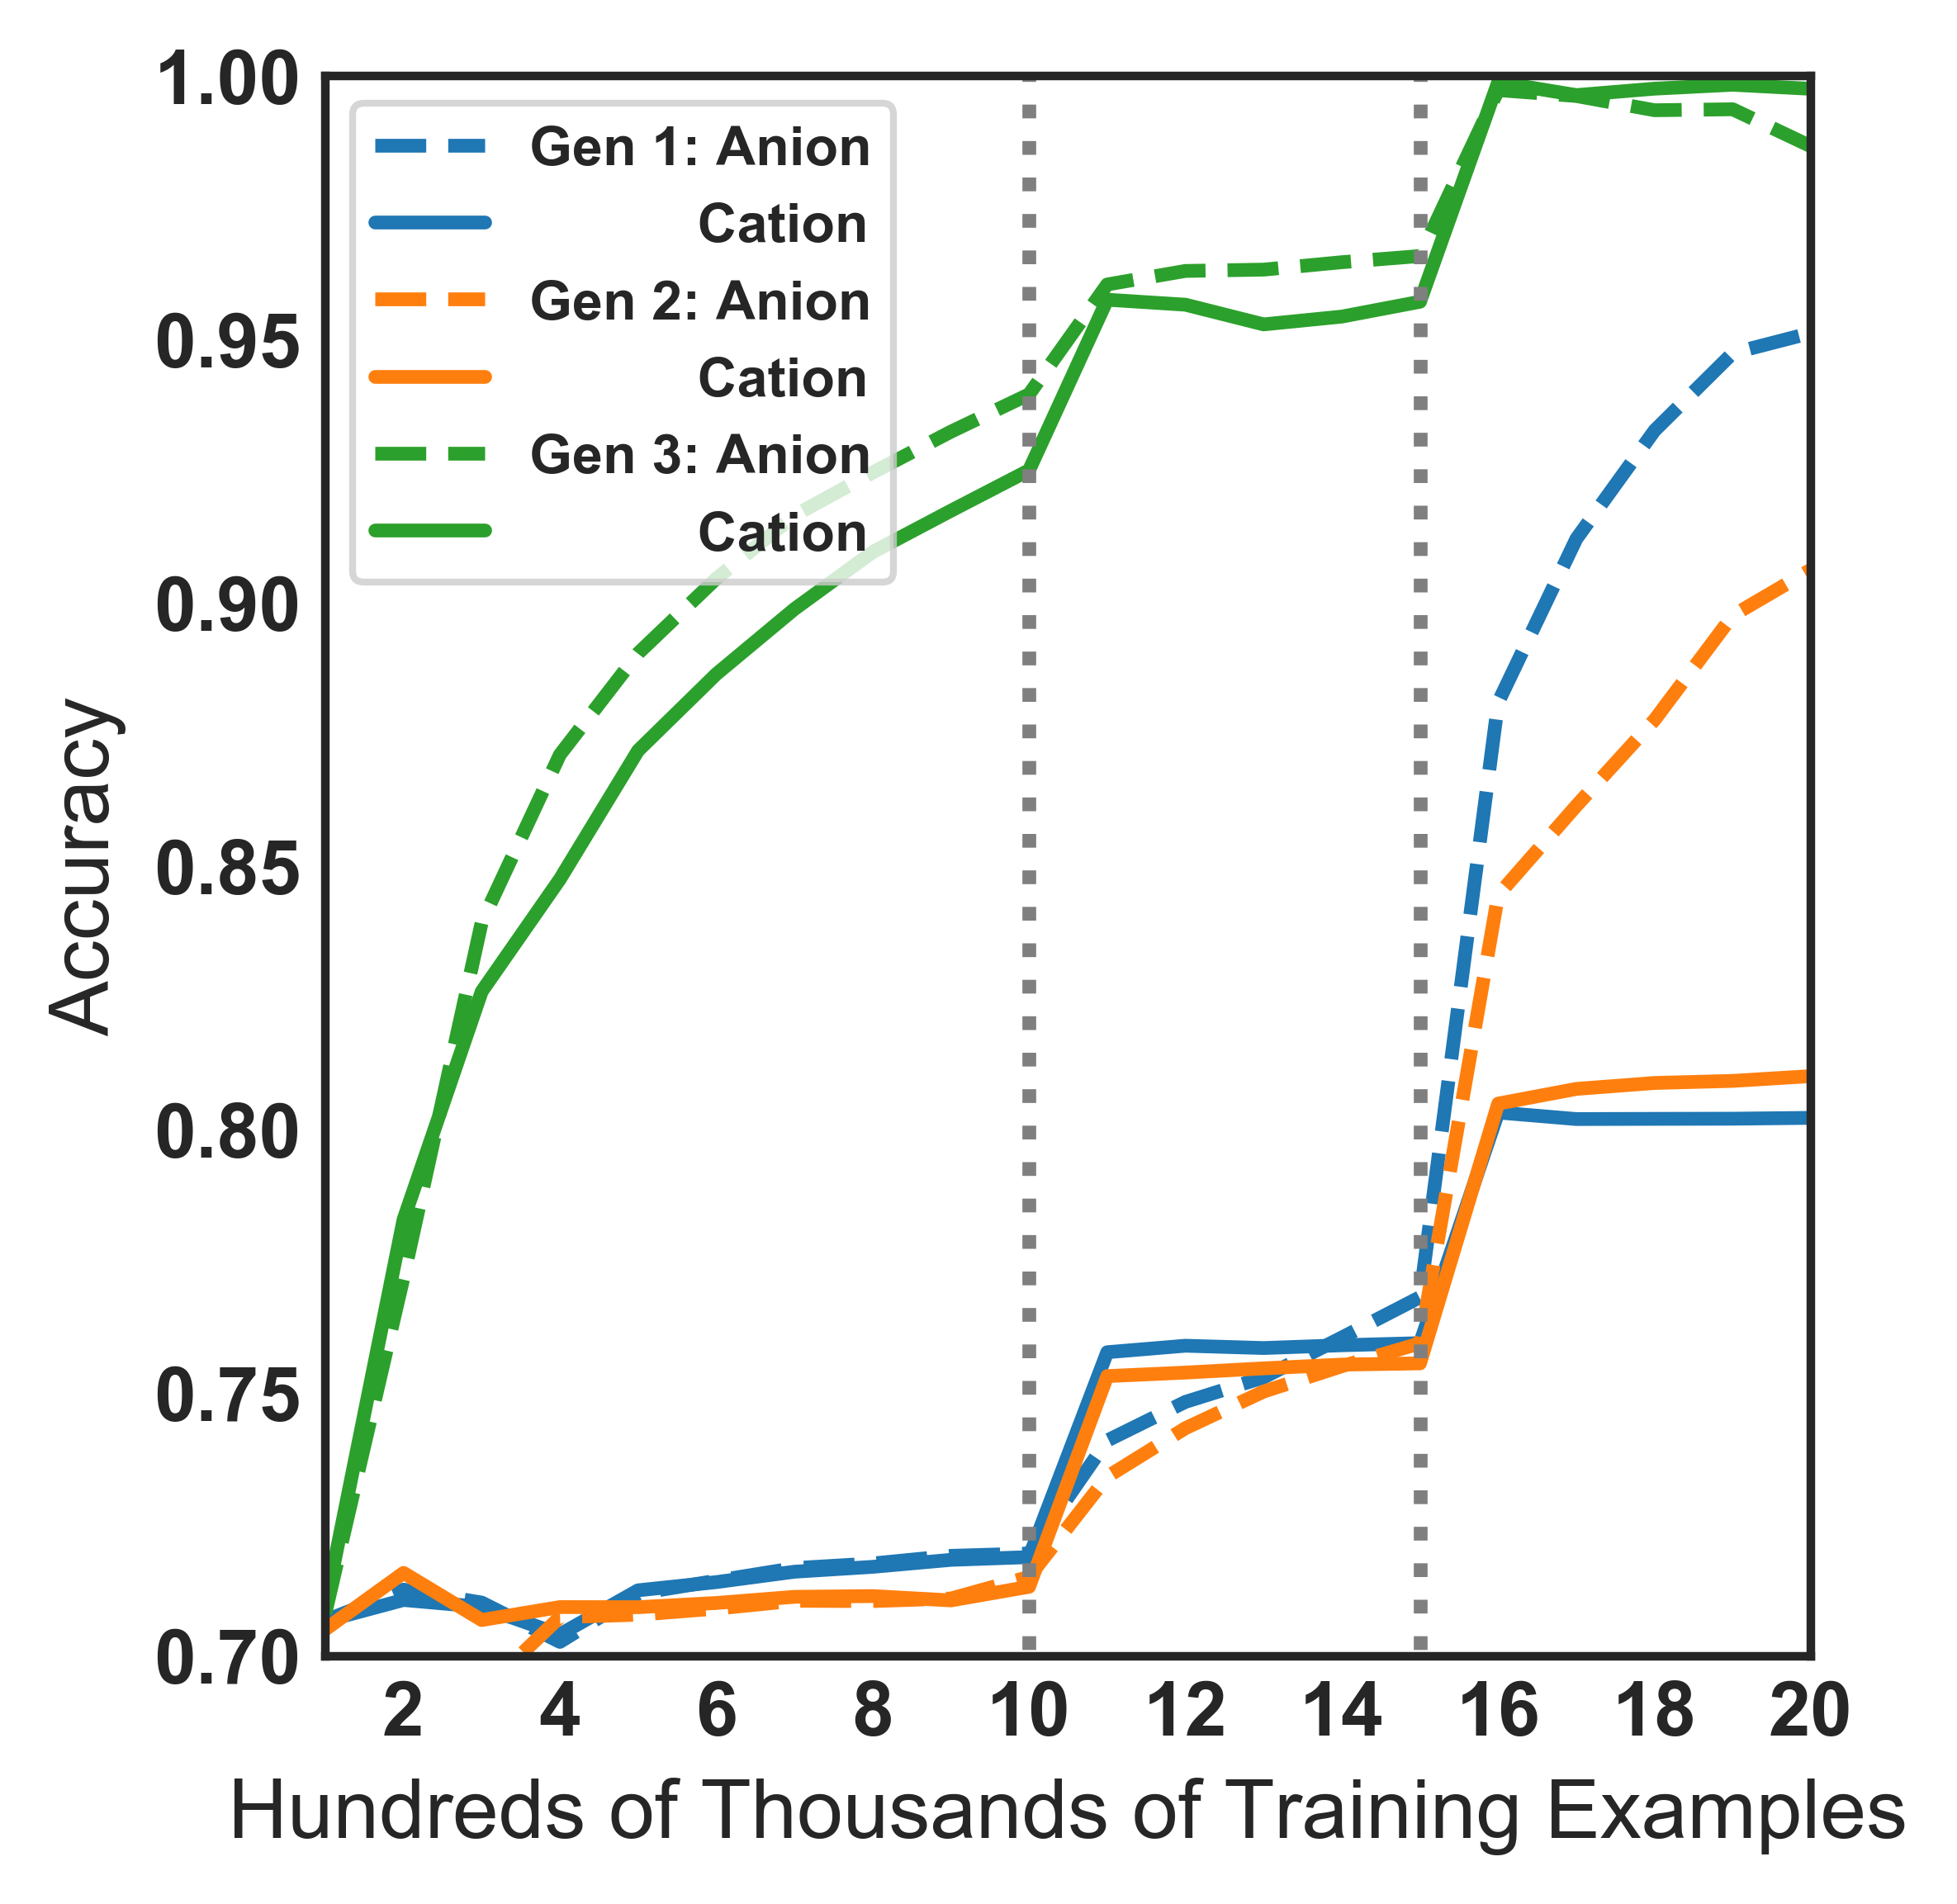

In [42]:
from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator

%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1, figsize=(4.3,4.3), dpi=300)
    tab = my_colors()
    for i in range(3):
        print
        col=next(tab)
        #with open('../models/histories/{}'.format(histories[i]), 'r') as f:
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)
        cat = []
        ani = []
        for epoch in hist:
            if i == 0:
                ani.append(epoch['decoded_anion_mean_acc'][0])
                cat.append(epoch['decoded_cation_mean_acc'][0])
            else:
                ani.append(epoch['anion_decoded_mean_acc'][0])
                cat.append(epoch['cation_decoded_mean_acc'][0])
        ax.plot(np.arange(1,21), ani, ls='--', label="Gen {}: Anion".format(i+1), c=col)
        ax.plot(np.arange(1,21), cat, ls='-', label="           Cation".format(i+1), c=col)
        ax.set_xlim(1,20,1)
        ax.set_ylim(0.7,1)
        ax.set_ylabel('Accuracy', fontsize = 12)
        ax.set_xlabel('Hundreds of Thousands of Training Examples', fontsize = 12)
        
        ax.legend(loc=2, frameon=True, fontsize=8)
    ax.plot([10,10],[0.6,1.1], ls=':', c='tab:grey')
    ax.plot([15,15],[0.6,1.1], ls=':', c='tab:grey')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    fig.tight_layout()
    #plt.grid()

In [44]:
fig.savefig('assets/fig2a.svg', bbox_inches='tight', dpi=300)

In [45]:
import os
histories = []
for root, dirs, files in os.walk("../models/histories"):  
    for filename in files:
        if 'history' in filename:
            if 'gen3vae' in filename:
                if '100' in filename:
                    if 'melting' not in filename:
                        if (filename.split('_')[3] == '100.json') or (filename.split('_')[3] == 'conductivity'):
                            histories.append(filename)
histories

['history_gen3vae_thermal_conductivity_100.json',
 'history_gen3vae_density_100.json',
 'history_gen3vae_cpt_100.json',
 'history_gen3vae_viscosity_100.json']

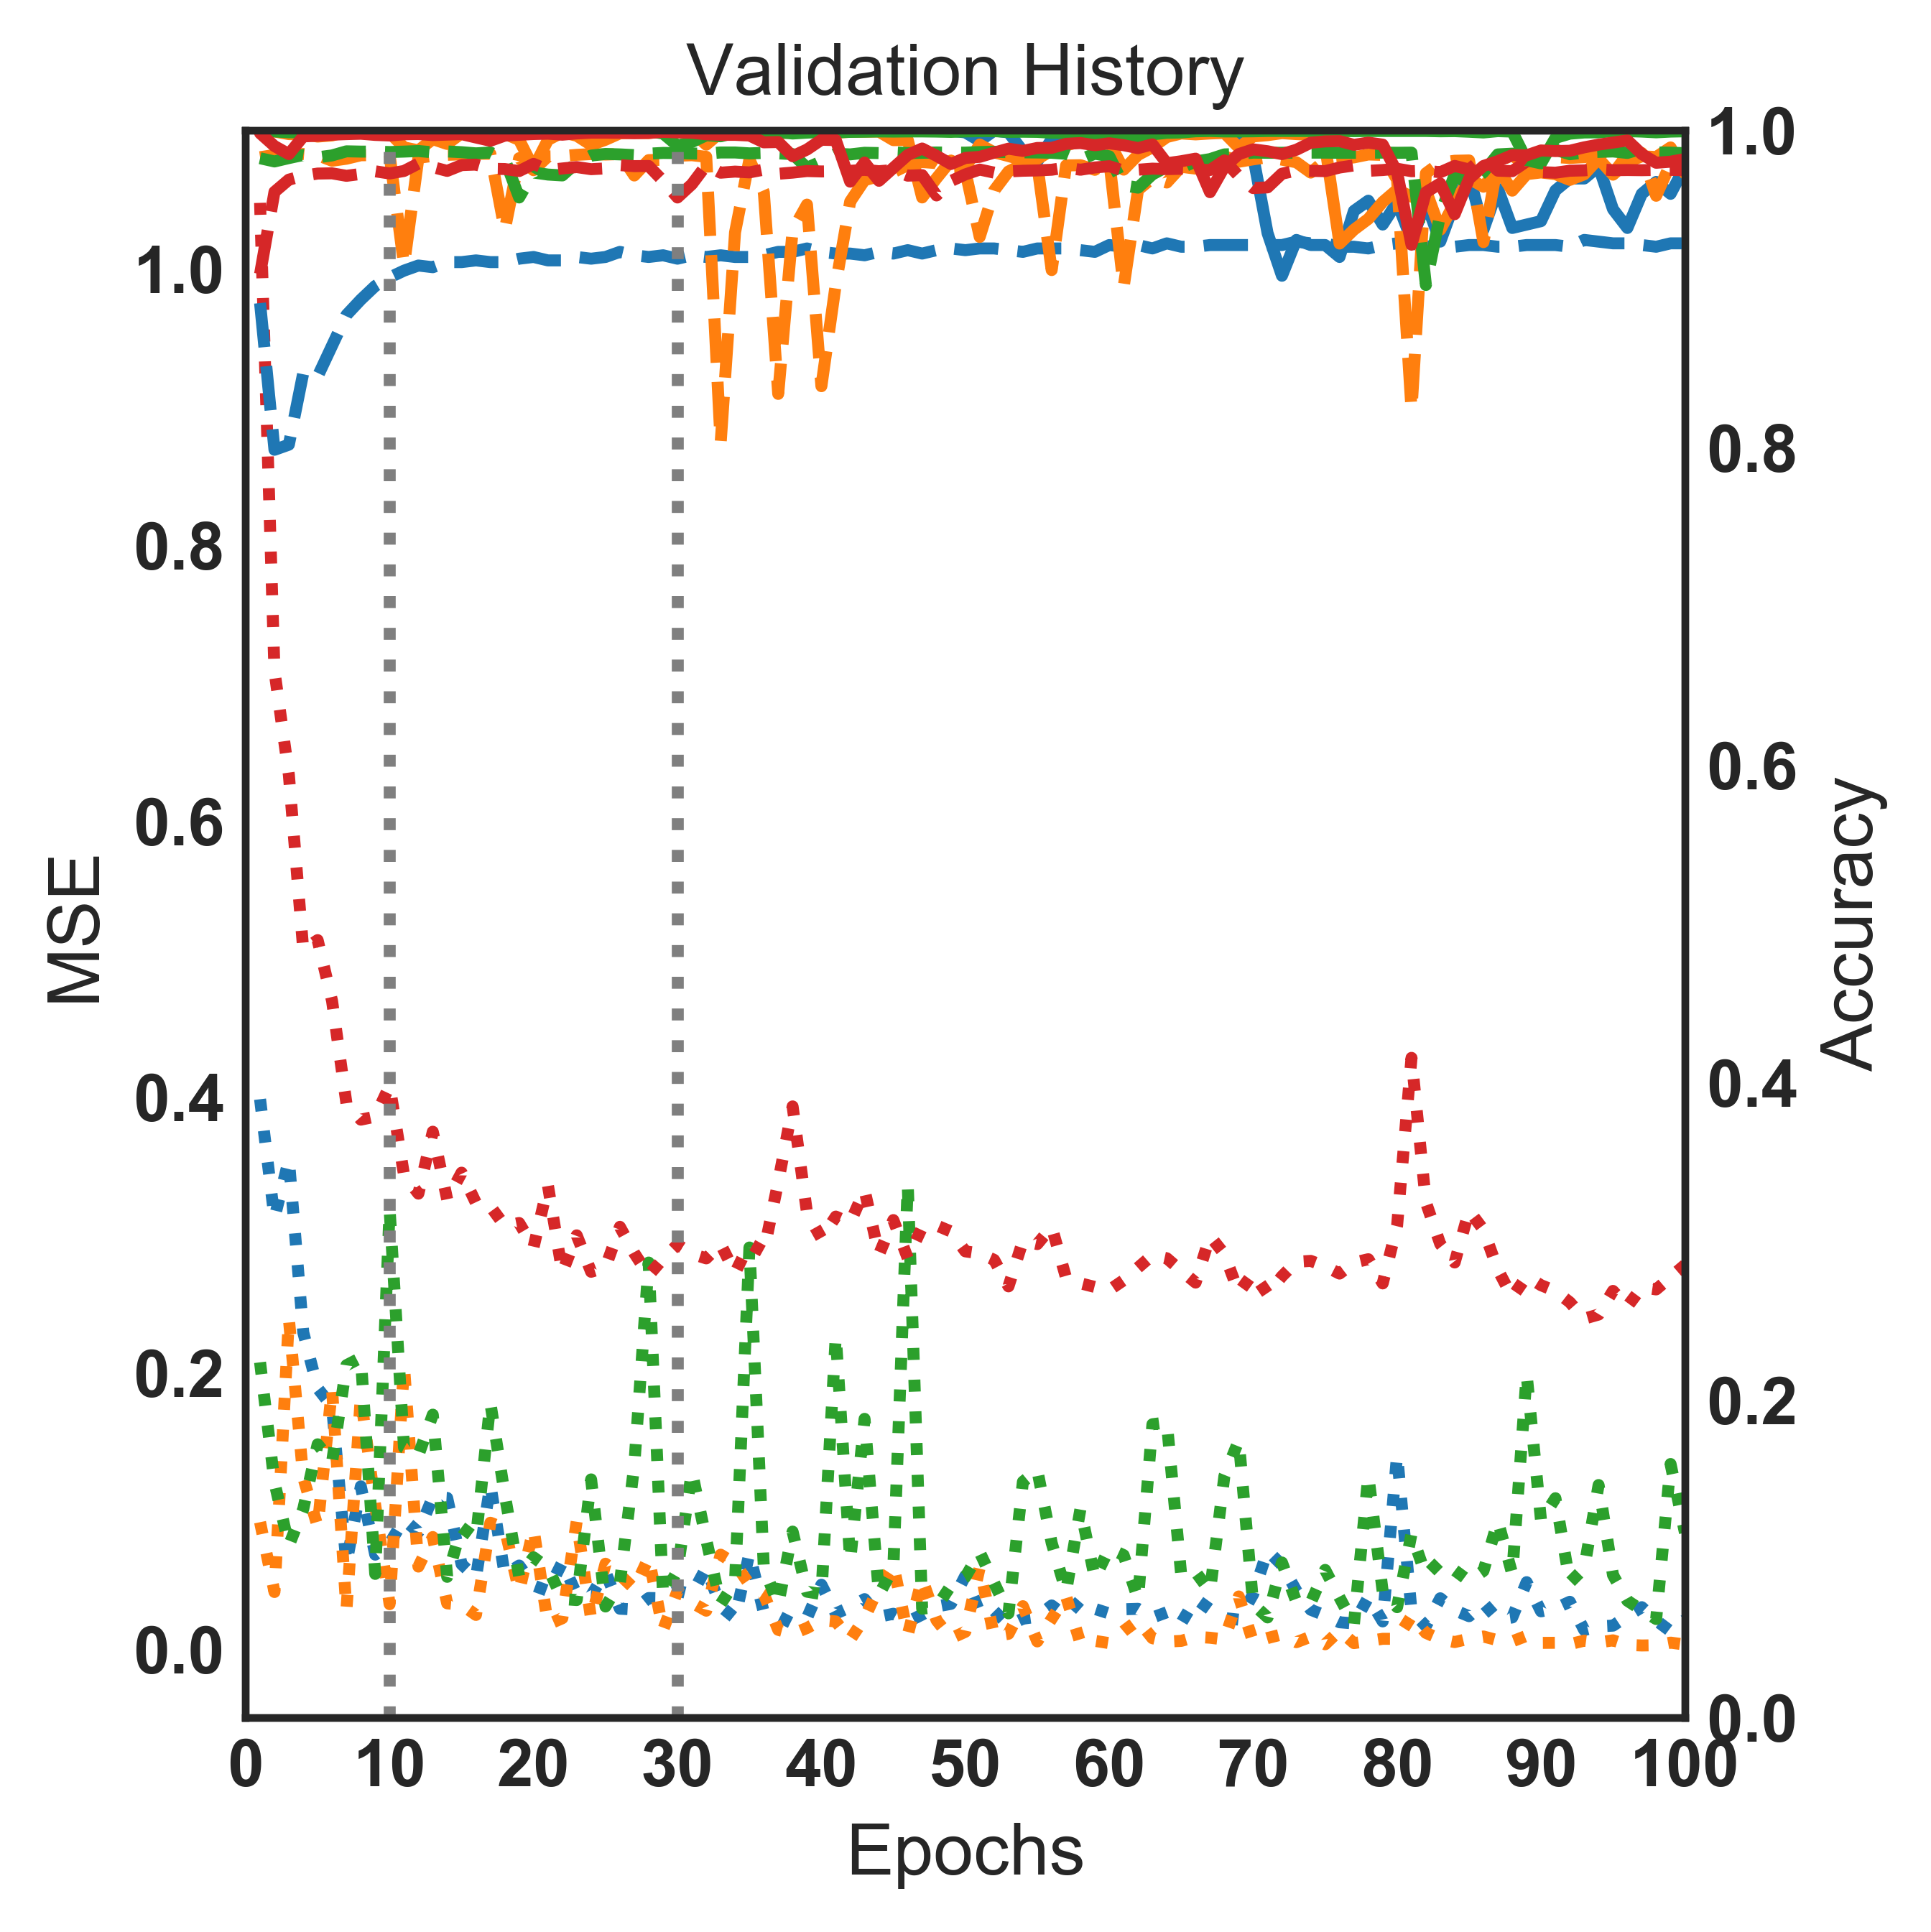

In [46]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 24}

matplotlib.rc('font', **font)
#rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = False

from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(4):
        col=next(tab)
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)


        ax2.plot(np.arange(1,101,1), hist['val_anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['val_cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['val_qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
        
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
#         ax2.set_ylim(0.7,1.1)
        
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        #ax2.legend(h1+h2, l1+l2, frameon=True, bbox_to_anchor=(1.7, .85))
        
    ax2.plot([10,10],[0,1], ls=':', c='tab:grey')
    ax2.plot([30,30],[0,1], ls=':', c='tab:grey')
    
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax.set_title('Validation History')
    ax2.grid()
    ax.grid()
    fig.tight_layout()
ax.grid()
ax2.grid()

In [47]:
# fig.savefig('assets/fig4a.svg', bbox_inches='tight', dpi=300)

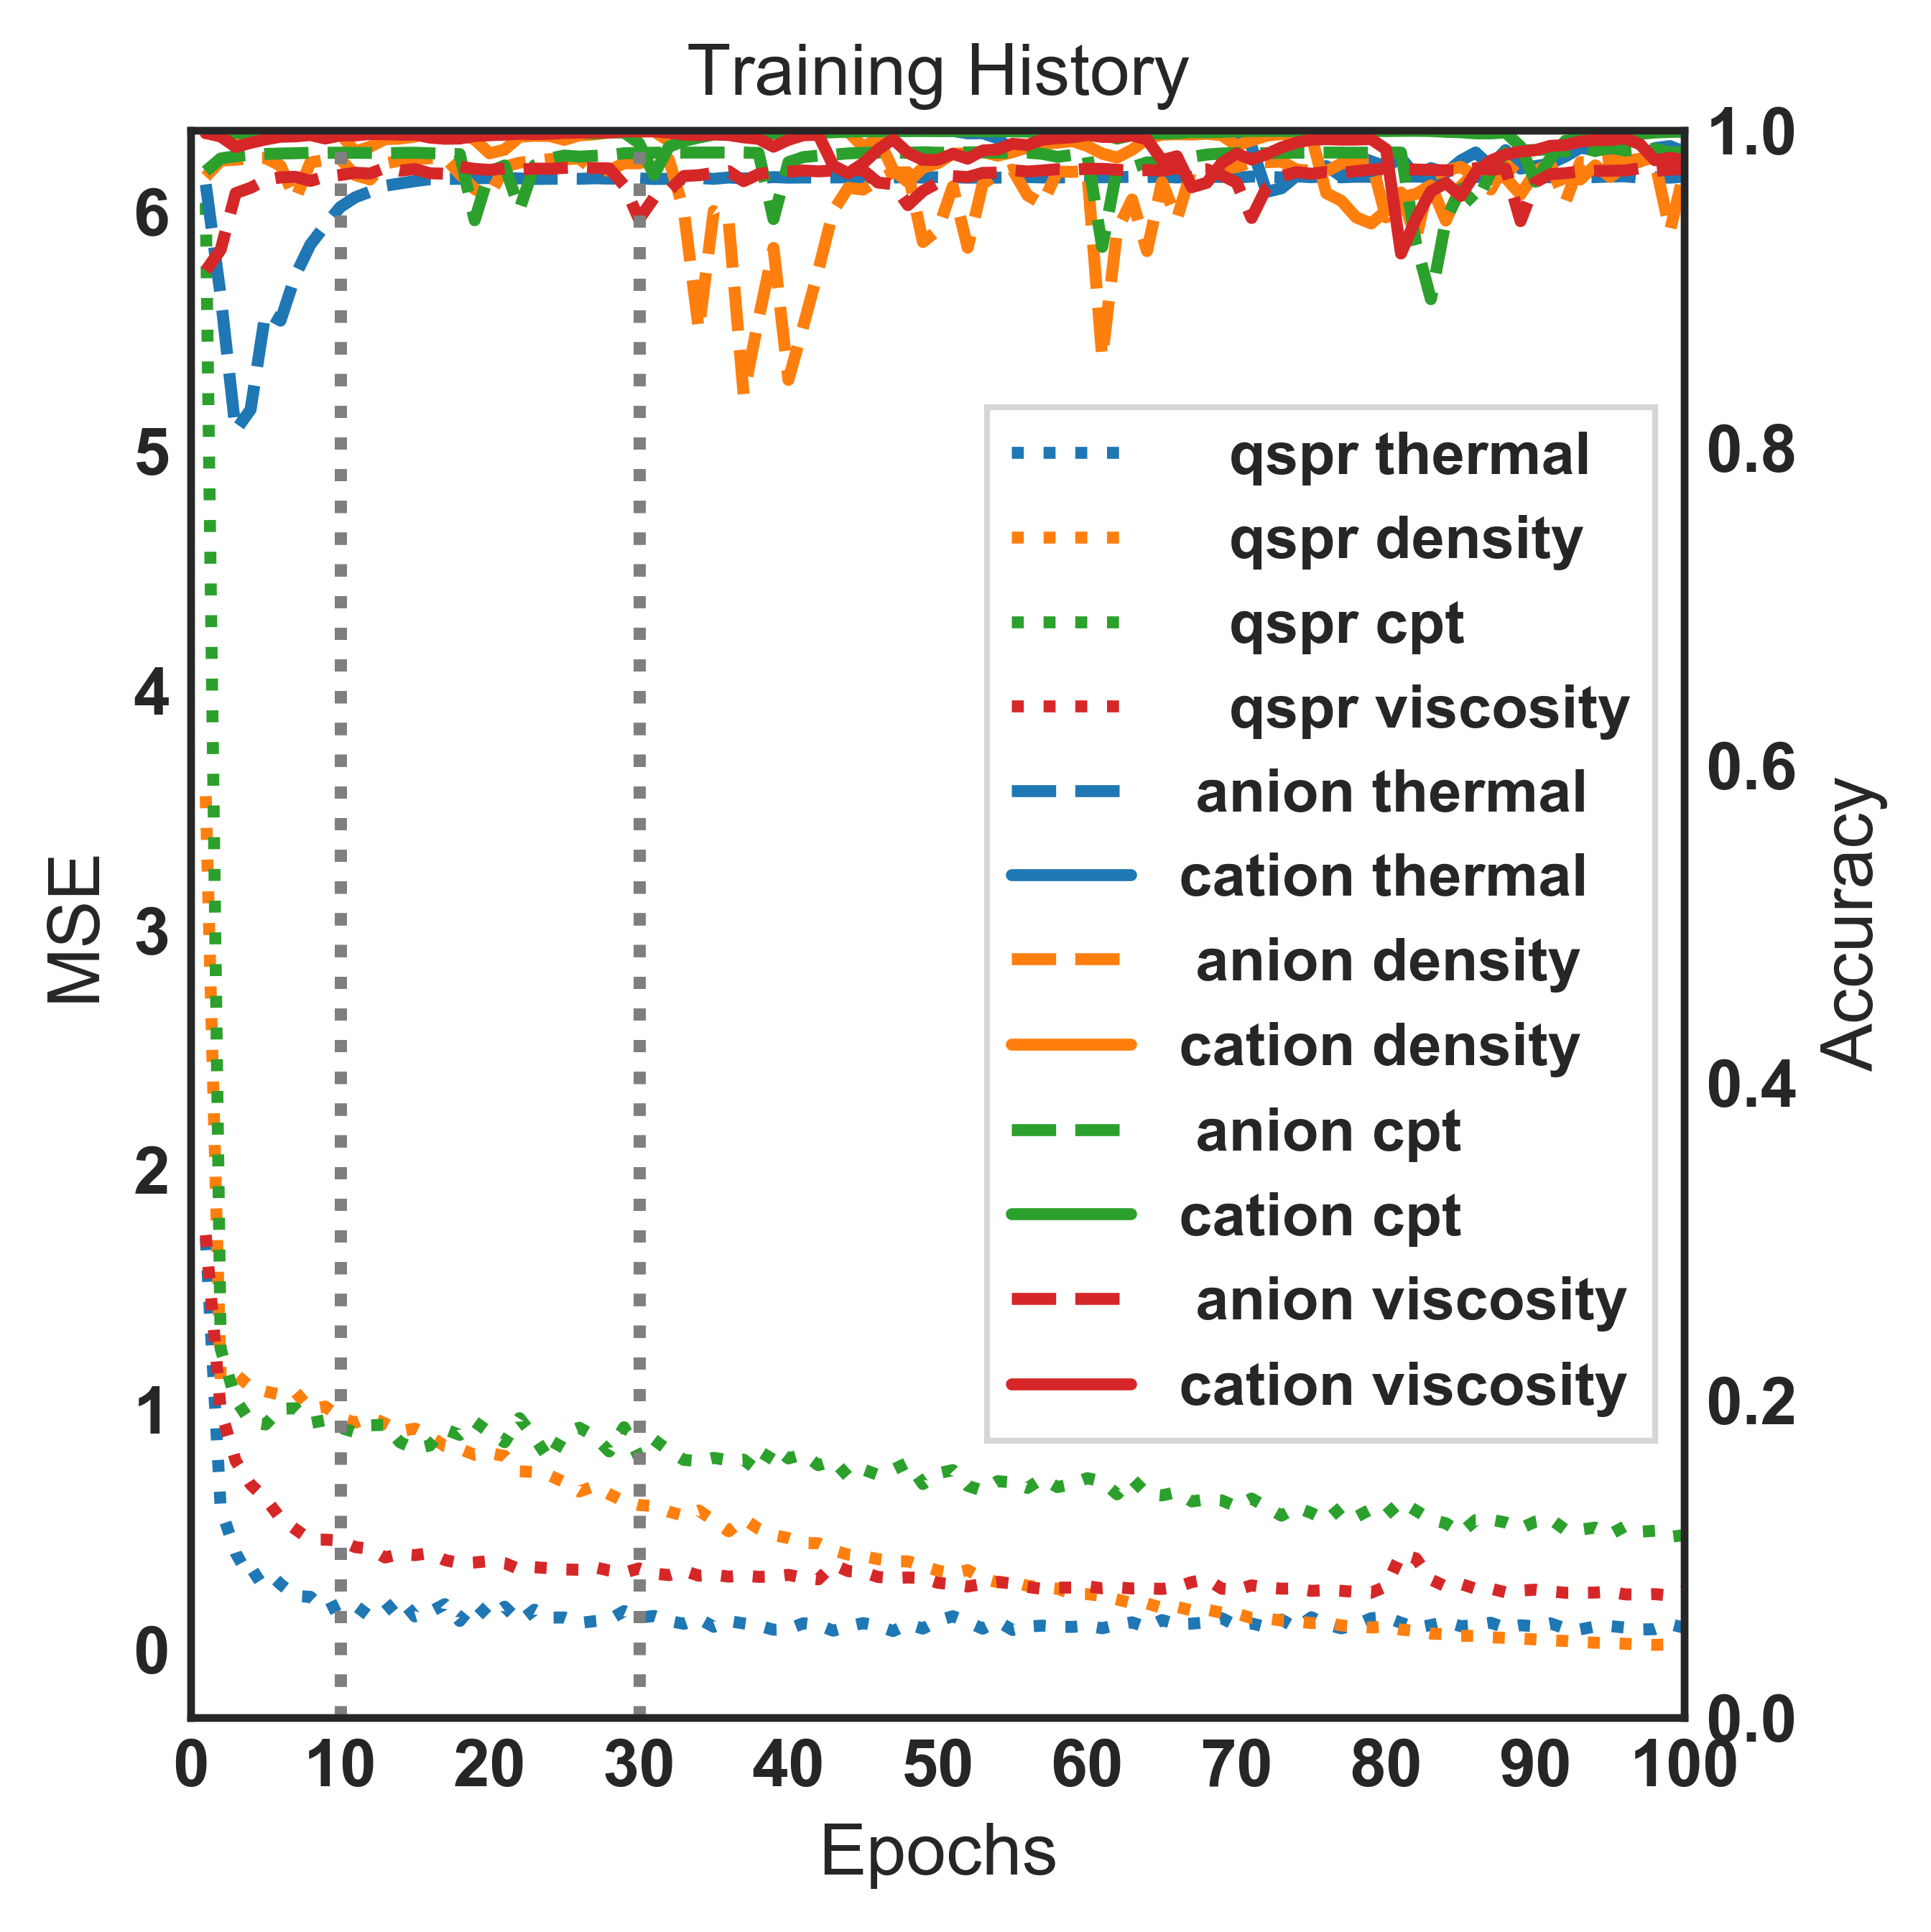

In [48]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 24}

matplotlib.rc('font', **font)
#rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = False

from matplotlib.ticker import MaxNLocator  ## Import MaxNLocator
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    ax2 = ax.twinx()
    tab = my_colors()
    for i in range(4):
        col=next(tab)
        with open('../models/histories/{}'.format(histories[i]), 'r') as f:
            hist = json.load(f)

        ax2.plot(np.arange(1,101,1), hist['anion_decoded_mean_acc'], ls='--', label=" anion {}".format(histories[i].split('_')[2]), c=col)
        ax2.plot(np.arange(1,101,1), hist['cation_decoded_mean_acc'], ls='-', label="cation {}".format(histories[i].split('_')[2]), c=col)
        ax.plot(np.arange(1,101,1), hist['qspr_mean_squared_error'], ls=':', label="   qspr {}".format(histories[i].split('_')[2]), c=col)
               
        ax.set_xlim(0,100,1)
        ax2.set_ylim(0,1)
        ax.set_ylabel('MSE')
        ax2.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax2.plot([10,10],[0,1], ls=':', c='tab:grey')
        ax2.plot([30,30],[0,1], ls=':', c='tab:grey')
        ax2.legend(h1+h2, l1+l2, frameon=True, framealpha=0.8, loc='right', fontsize=10)#, bbox_to_anchor=(1.7, .85))

    ax.set_title('Training History')
    x_ax = ax.axes.get_xaxis()  ## Get X axis
    x_ax.set_major_locator(MaxNLocator(integer=True))  ## Set major locators to integer values
    ax2.grid()
    ax.grid()
    fig.tight_layout()
ax2.grid()
ax.grid()

In [49]:
# fig.savefig('assets/fig4b.svg', bbox_inches='tight', dpi=300)

In [50]:
properties = ['cpt', 'thermal_conductivity'] #can change to whatever two properties
T = [297, 316] #state variables for target property values (visc, cpt, therm... etc)
P = [99, 102]

devmodel = salty.aggregate_data(properties, T=T, P=P, merge='overlap')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
cpt_thermal_salts = devmodel.Data['smiles_string']
cpt_thermal_salts = cpt_thermal_salts.reset_index(drop=True)
cpt_thermal_salts = cpt_thermal_salts.unique()

cpt_thermal_cations = [i.split('.')[0] for i in cpt_thermal_salts]
cpt_thermal_anions = [i.split('.')[1] for i in cpt_thermal_salts]

/Users/prguser/opt/anaconda3/envs/gen_salt/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [12]:
print('models/gen3vae_{}_{}_100.h5'.format(properties[0], properties[1]))

models/gen3vae_cpt_thermal_conductivity_100.h5


In [13]:
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char

In [14]:

gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, 
               weights_file='../models/gen3vae_{}_{}_100.h5'.format(properties[0], properties[1]),
              qspr_outputs = 2)

In [15]:
model_1 = [properties[0]]
salts_1, cations_1, target_1 = return_top_cations(model_1, return_min_values=True)
model_2 = [properties[1]]
salts_2, cations_2, target_2 = return_top_cations(model_2, return_min_values=True)

/Users/prguser/opt/anaconda3/envs/gen_salt/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned
Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	23
unique cations:	10
min/max values:	0.1667, 0.2380

salts sorted in descending order and the minimum value of the top 10 unique cations was returned


/Users/prguser/opt/anaconda3/envs/gen_salt/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [18]:
cations_2

array(['Cn1cc[n+](c1)C', 'CCn1cc[n+](c1)C', 'CC[n+]1cn(cc1)C',
       'CCCCn1cc[n+](c1)C', 'CCCCCCn1cc[n+](c1)C', 'Cn1c[n+](cc1)CCC',
       'CCCC[N+](C)(CCCC)CCCC', 'CCCC[n+]1ccccc1',
       'CCCCCCCCn1cc[n+](c1)C', 'Cn1cc[n+](c1)CCCCCCCCCC'], dtype=object)

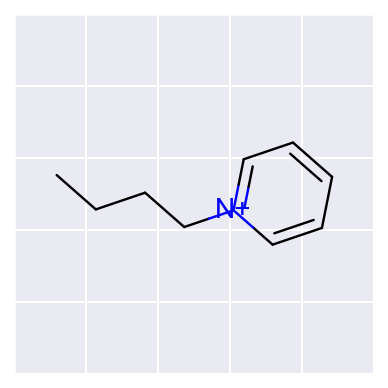

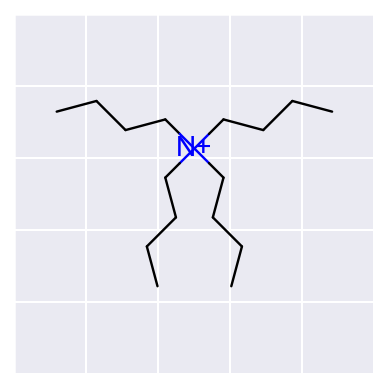

In [20]:
# cat1 = 'CCCCCCCCCCn1cc[n+](c1)'
# #cat1 = 'CCCCCCCn1cc[n+](c1)'
# cat2 = 'CCCC[N+](C)(CCCC)CCCC'
# mid_cat = 'CCCC[P+](C)(CCCC)CCCC'
# #cat1 = 'CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC'
# #cat1 = cations_1[random.randint(0,len(cations_1)-1)]
# im1 = Draw.MolToImage(Chem.MolFromSmiles(cat1), size=(100,100))
# #cat2 = cations_2[random.randint(0,len(cations_1)-1)]
# im2 = Draw.MolToImage(Chem.MolFromSmiles(cat2), size=(100,100))

# cat1 = 'CCCCCCCCCCCCCCn1cc[n+](c1)C'
# cat2 = 'C1=C[N+](CCC)=CN1CCC'
cat2 = 'CCCC[N+](CCCC)(CCCC)CCCC'
cat1 = 'CCCC[n+]1ccccc1'

# cat1 = cations_1[random.randint(0,len(cations_1)-1)]
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cat1), size=(100,100))
# cat2 = cations_2[random.randint(0,len(cations_1)-1)]
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cat2), size=(100,100))

values = [cat1,cat2]

z = []
for smi in salts:
    smi = smi.split('.')[0]
    z_i = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    z.append(z_i[0])
z = np.array(z)

zt = []
for smi in values:
    zti = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    zt.append(zti[0])
zt = np.array(zt)
# we can interpolate between these molecules...
ps = array([slerp(zt[0], zt[1], t) for t in np.arange(0.0, 1.0, 0.1)])

zt = np.concatenate([zt, ps])
pca = PCA(n_components=50)
pcs = pca.fit_transform(z)
pcst = pca.transform(zt)

In [22]:
from rdkit.Chem.Draw import rdMolDraw2D
mid_cat = 'CCCC[N+]1CCCC1C'
name = Chem.MolFromSmiles(cat2)
d2d = rdMolDraw2D.MolDraw2DSVG(450,200)
#d2d = rdMolDraw2D.MolDraw2DSVG()
d2d.SetFontSize(1)
#d2d.drawOptions().atomLabelFontSize = 24
#d2d.drawOptions().addAtomIndices=True
d2d.drawOptions().bondLineWidth=7
d2d.DrawMolecule(name)
d2d.FinishDrawing()
imag = SVG(d2d.GetDrawingText())

from cairosvg import svg2svg
svg2svg(bytestring=imag.data,write_to='stop.svg')

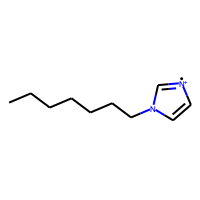

In [11]:
cat2 = 'CCCCCCCn1cc[n+](c1)'
cat1 = 'CCCC[N+](C)(CCCC)CCCC'
Draw.MolToImage(Chem.MolFromSmiles(cat2), size=(200,200))

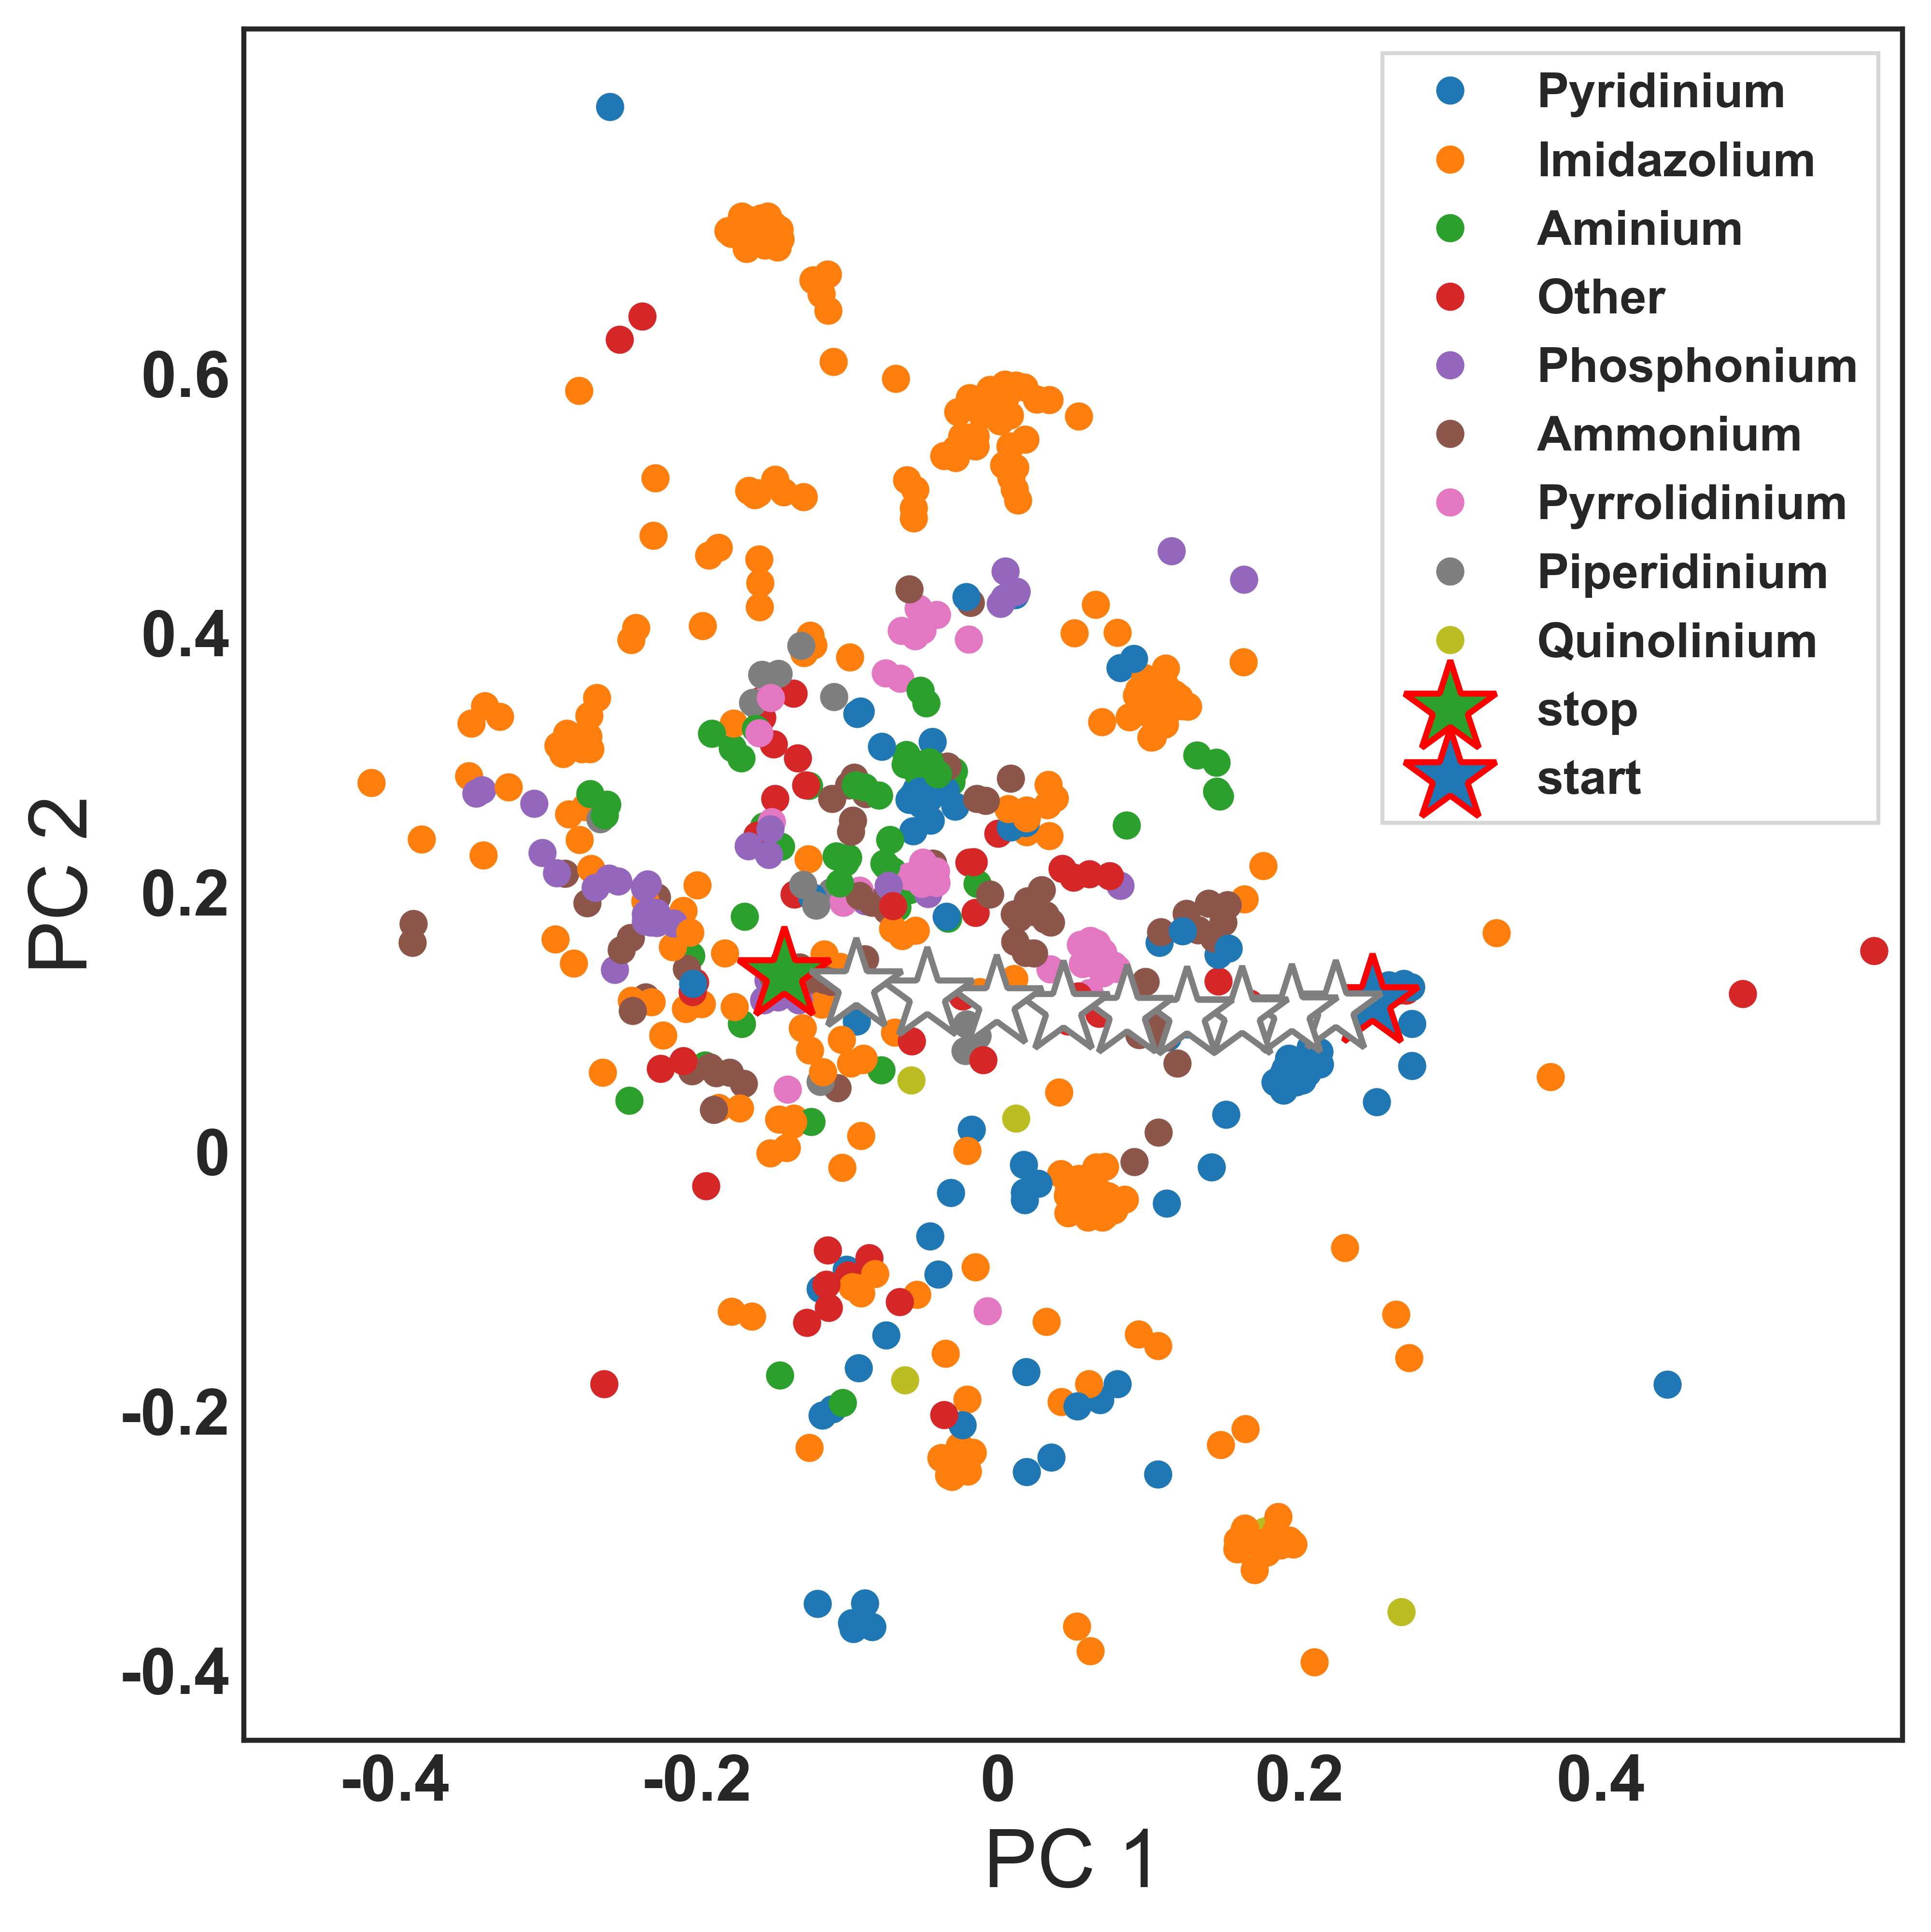

In [30]:
%config InlineBackend.figure_format = 'retina'

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
#rcParams['lines.linewidth'] = 2
rcParams["legend.fancybox"] = False

from collections import OrderedDict
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(7,7), dpi=300)
    ax1 = fig.add_subplot(111)
    for i in range(len(salt_categories)):
        x = pcs[i,0]
        y = pcs[i,1]
        ax1.plot(x, y, linestyle='', marker='.', 
                 color=coldic[salt_categories[i]], markersize=12, label=salt_categories[i])
    for index, targets in enumerate(pcst):

        if index == 2:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:blue', markersize=24, label='start', 
                     markeredgewidth=1.5, markeredgecolor='red')
        elif index == 1:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:green', markersize=24, label='stop',
                     markeredgewidth=1.5, markeredgecolor='red')
        else:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                     color='white', markersize=24,
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
#         ax1.text(targets[0], targets[1], '{}'.format(index), fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax1.set_ylabel('PC 2', size=20)
    ax1.set_xlabel('PC 1', size=20)
    ax1.set_xlim(-0.5,0.6)
    yticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]
    xticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4]
    ax1.set_xticklabels(xticks, fontsize=16)
    ax1.set_yticklabels(yticks, fontsize=16)
    plt.legend(by_label.values(), by_label.keys(), frameon=True, fontsize=12)
    plt.tight_layout()
    plt.grid()
plt.grid()

In [31]:
fig.savefig('assets/fig6.svg', bbox_inches='tight', dpi=300)

In [ ]:
df = interpolate_structures(gen3vae.cation_decoder, ps, char_to_index, limit=1e4, temp=2)

In [1]:
ms = [Chem.MolFromSmiles(smi) for smi in df1['smiles'] if '+' in smi]
print('M1 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m1_example_structures.png')
fig

NameError: name 'df1' is not defined

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in df5['smiles'] if '+' in smi]
print('M5 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m5_example_structures.png')
fig

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in df2['smiles'] if '+' in smi]
print('M2 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m2_example_structures.png')
fig

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in df4['smiles'] if '+' in smi]
print('M4 sample of + structures')
fig = Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:50]])
fig.save('assets/m4_example_structures.png')
fig

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df1, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M1'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df4, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M4'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])

In [ ]:
ms = [Chem.MolFromSmiles(smi) for smi in pd.merge(df2, df5, how='inner', on='smiles')['smiles']]
print('{} structures shared by M5 and M2'.format(len(ms)))
Draw.MolsToGridImage(ms[:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])